<h1 style="text-align:center;">Proton - Data Analyst Take Home Assignment</h1>

# Import libraries

In [1]:
import pandas as pd
import numpy as np

# Graphs
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
import scipy.stats as stats

# Display all columns
pd.set_option('display.max_columns', None)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import .csv source files

In [2]:
vpn_customer_data = pd.read_csv('data/vpn_customer_data.csv')
vpn_customer_data.head()

,user_id,signup_date,signup_country,churn_date,plan,plan_price,monthly_usage_hours,countries_connected_to,devices_used,num_tickets,support_tickets
0,1,2023-05-25,DE,2023-09-22,monthly,9.99,69,10,mobile,1,account
1,2,2023-06-23,US,2024-11-14,monthly,9.99,197,5,"tablet,mobile,smart-tv",2,"account,technical"
2,3,2023-04-27,US,2023-11-23,monthly,9.99,107,6,"tablet,desktop,tablet,tablet",1,billing
3,4,2023-08-24,FR,2024-10-17,monthly,9.99,120,6,"smart-tv,smart-tv,mobile",2,"technical,technical"
4,5,2024-03-18,US,2024-11-13,monthly,9.99,121,5,"smart-tv,smart-tv",2,"account,account"


In [3]:
vpn_events = pd.read_csv('data/vpn_events.csv')
vpn_events.head()

,event_type,country,date,description,impact_score
0,employment,JP,2023-10-14 22:02:22.837416,Major industry changes affecting employment in JP,3
1,employment,FR,2023-10-14 22:02:22.837416,Major industry changes affecting employment in FR,3
2,employment,US,2023-10-14 22:02:22.837416,Major industry changes affecting employment in US,3
3,employment,DE,2024-09-28 22:02:22.837416,Major industry changes affecting employment in DE,3
4,employment,US,2024-09-28 22:02:22.837416,Major industry changes affecting employment in US,3


In [4]:
vpn_external_factors = pd.read_csv('data/vpn_external_factors.csv')
vpn_external_factors.head()

,date,country,vpn_friendly,internet_freedom_index,remote_work_adoption,employment_rate
0,2023-02-08,US,0.9,85.0,45,95.0
1,2023-02-09,US,0.9,85.0,45,95.0
2,2023-02-10,US,0.9,85.0,45,95.0
3,2023-02-11,US,0.9,85.0,45,95.0
4,2023-02-12,US,0.9,85.0,45,95.0


# Data Cleaning

## vpn_customer_data

In [5]:
vpn_customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 100000 non-null  int64  
 1   signup_date             100000 non-null  object 
 2   signup_country          100000 non-null  object 
 3   churn_date              40043 non-null   object 
 4   plan                    100000 non-null  object 
 5   plan_price              100000 non-null  float64
 6   monthly_usage_hours     100000 non-null  int64  
 7   countries_connected_to  100000 non-null  int64  
 8   devices_used            100000 non-null  object 
 9   num_tickets             100000 non-null  int64  
 10  support_tickets         75291 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 8.4+ MB


The missing values correspond to churn_date column which makes sense as not everyone has churned and support_tickets column which is coherent as not everyone has submited tickets.

In [6]:
# Calculate missing values
vpn_customer_data.isnull().sum()

user_id                       0
signup_date                   0
signup_country                0
churn_date                59957
plan                          0
plan_price                    0
monthly_usage_hours           0
countries_connected_to        0
devices_used                  0
num_tickets                   0
support_tickets           24709
dtype: int64

In [7]:
# Check there is only paid plans in customer data
vpn_customer_data.plan_price.unique()

array([ 9.99, 59.88])

In [8]:
# Add a churned column
vpn_customer_data['churned'] = np.where(vpn_customer_data['churn_date'].isnull(), 0, 1)

In [9]:
# Convert signup_date and churn date to datetime and remove time as we will not be focusing on time analysis
vpn_customer_data['signup_date'] = pd.to_datetime(vpn_customer_data['signup_date']).dt.normalize()
vpn_customer_data['churn_date'] = pd.to_datetime(vpn_customer_data['churn_date']).dt.normalize()

In [10]:
# Add num_devices column: count the number of devices used (including duplicates)
vpn_customer_data['num_devices'] = vpn_customer_data['devices_used'].str.split(',').str.len()

# Add num_distinct_devices column: count the number of distinct devices used
vpn_customer_data['num_distinct_devices'] = vpn_customer_data['devices_used'].str.split(',').apply(lambda x: len(set(x)))

In [11]:
# Create devices frequency columns
devices_split = vpn_customer_data['devices_used'].str.split(',', expand=True)
devices_counts = pd.get_dummies(devices_split.stack()).groupby(level=0).sum()
devices_counts = devices_counts.add_prefix('devices_')
vpn_customer_data = pd.concat([vpn_customer_data, devices_counts], axis=1)

In [12]:
# Drop the original devices_used column since we've frequency columns
vpn_customer_data = vpn_customer_data.drop('devices_used', axis=1)

In [13]:
# Create support_tickets frequency columns
support_tickets_split = vpn_customer_data['support_tickets'].str.split(',', expand=True)
support_tickets_counts = pd.get_dummies(support_tickets_split.stack()).groupby(level=0).sum()
support_tickets_counts = support_tickets_counts.add_prefix('support_tickets_')
vpn_customer_data = pd.concat([vpn_customer_data, support_tickets_counts], axis=1)

In [14]:
# Fill NaN values with 0 for all support ticket columns
support_ticket_cols = [col for col in vpn_customer_data.columns if col.startswith('support_tickets_')]
vpn_customer_data[support_ticket_cols] = vpn_customer_data[support_ticket_cols].fillna(0).astype(int)

In [15]:
# Drop the original support_tickets column since we've created frequency columns
vpn_customer_data = vpn_customer_data.drop('support_tickets', axis=1)

In [16]:
vpn_customer_data.head(10)

,user_id,signup_date,signup_country,churn_date,plan,plan_price,monthly_usage_hours,countries_connected_to,num_tickets,churned,num_devices,num_distinct_devices,devices_desktop,devices_mobile,devices_smart-tv,devices_tablet,support_tickets_account,support_tickets_billing,support_tickets_connection,support_tickets_technical
0,1,2023-05-25,DE,2023-09-22,monthly,9.99,69,10,1,1,1,1,0,1,0,0,1,0,0,0
1,2,2023-06-23,US,2024-11-14,monthly,9.99,197,5,2,1,3,3,0,1,1,1,1,0,0,1
2,3,2023-04-27,US,2023-11-23,monthly,9.99,107,6,1,1,4,2,1,0,0,3,0,1,0,0
3,4,2023-08-24,FR,2024-10-17,monthly,9.99,120,6,2,1,3,2,0,1,2,0,0,0,0,2
4,5,2024-03-18,US,2024-11-13,monthly,9.99,121,5,2,1,2,1,0,0,2,0,2,0,0,0
5,6,2025-01-09,CA,NaT,monthly,9.99,52,2,0,0,3,2,2,1,0,0,0,0,0,0
6,7,2023-10-26,FR,2024-10-28,annual,59.88,80,3,1,1,4,2,3,1,0,0,0,0,1,0
7,8,2023-09-16,UK,NaT,annual,59.88,46,5,1,0,4,3,0,1,1,2,0,0,1,0
8,9,2025-01-18,JP,NaT,monthly,9.99,151,2,2,0,4,3,2,1,1,0,1,1,0,0
9,10,2024-09-19,UK,NaT,monthly,9.99,100,9,1,0,2,2,0,1,1,0,0,0,0,1


In [17]:
vpn_customer_data.describe(include='all')

,user_id,signup_date,signup_country,churn_date,plan,plan_price,monthly_usage_hours,countries_connected_to,num_tickets,churned,num_devices,num_distinct_devices,devices_desktop,devices_mobile,devices_smart-tv,devices_tablet,support_tickets_account,support_tickets_billing,support_tickets_connection,support_tickets_technical
count,100000.000000,100000,100000,40043,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
unique,NaN,NaN,8,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,US,NaN,monthly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,25416,NaN,56811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,50000.500000,2024-02-10 16:09:45.216000,NaN,2024-05-18 14:25:15.950353152,NaN,31.536992,136.112310,5.495730,1.508430,0.400430,2.500220,1.946550,0.625110,0.624470,0.626300,0.62434,0.378020,0.378120,0.371760,0.380530
min,1.000000,2023-02-08 00:00:00,NaN,2023-03-10 00:00:00,NaN,9.990000,20.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,25000.750000,2023-08-17 00:00:00,NaN,2024-01-14 00:00:00,NaN,9.990000,89.000000,3.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,50000.500000,2024-02-06 12:00:00,NaN,2024-06-08 00:00:00,NaN,9.990000,113.000000,5.000000,2.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,75000.250000,2024-08-17 00:00:00,NaN,2024-10-15 00:00:00,NaN,59.880000,146.000000,8.000000,3.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
max,100000.000000,2025-02-07 00:00:00,NaN,2025-02-22 00:00:00,NaN,59.880000,1055.000000,10.000000,3.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,3.000000


**Key Insights:**
- Data has been collected over a year, from 2024-02-10 to 2025-02-07.
- Churn rate is 40.04%, which is very high which is why this is what we will investigate.
- We notice that there are only 2 plans (monthly and annualy) and 56.81% of customers have a monthly plan, which representes a higher churn risk.
- Device distribution is well balanced with approximatively 62.5% usage for each.
- Support tickets distribution is also well balanced with approximatively 38% each type. The maximum number of tickets raised is 3 over a year which suggest no extreme problem customers.
- Regarding usage patterns the average 136 hours/month, between 4 to 5 hours a day. However we notice a wide range of usage which means very different user segments. As the median is lower than the average we can suspect some power users skewing the average.
- countries_connected_to show some geography diversity as on average users connect to 5.5 countries with a range from 1 to 10. USA is the top signup country.

## vpn_events

In [18]:
vpn_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   event_type    18 non-null     object
 1   country       18 non-null     object
 2   date          18 non-null     object
 3   description   18 non-null     object
 4   impact_score  18 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 852.0+ bytes


There is no missing data.

In [19]:
# Convert date to datetime and remove time as we will not be focusing on time analysis
vpn_events['date'] = pd.to_datetime(vpn_events['date']).dt.normalize()

In [20]:
vpn_events.describe(include='all')

,event_type,country,date,description,impact_score
count,18,18,18,18,18.000000
unique,4,9,NaN,17,NaN
top,employment,global,NaN,Major industry changes affecting employment in US,NaN
freq,6,4,NaN,2,NaN
mean,NaN,NaN,2024-03-10 01:20:00,NaN,4.444444
min,NaN,NaN,2023-06-02 00:00:00,NaN,3.000000
25%,NaN,NaN,2023-10-28 12:00:00,NaN,3.000000
50%,NaN,NaN,2024-03-01 00:00:00,NaN,4.000000
75%,NaN,NaN,2024-07-28 18:00:00,NaN,4.000000
max,NaN,NaN,2024-12-11 00:00:00,NaN,10.000000


## vpn_external_factors

### Global

In [21]:
vpn_external_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5848 entries, 0 to 5847
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    5848 non-null   object 
 1   country                 5848 non-null   object 
 2   vpn_friendly            5848 non-null   object 
 3   internet_freedom_index  5848 non-null   float64
 4   remote_work_adoption    5848 non-null   int64  
 5   employment_rate         5848 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 274.3+ KB


There is no missing data.

In [22]:
# Convert date to datetime and remove time as we will not be focusing on time analysis
vpn_external_factors['date'] = pd.to_datetime(vpn_external_factors['date']).dt.normalize()

### vpn_frienldy

In [23]:
# While willing to convert vpn_friendly to float, I obtain an error. Let's check the unique values
vpn_external_factors['vpn_friendly'].unique()

array(['0.9', '0.85', '0.8', 'False', '0.75', '0.7', '0.6'], dtype=object)

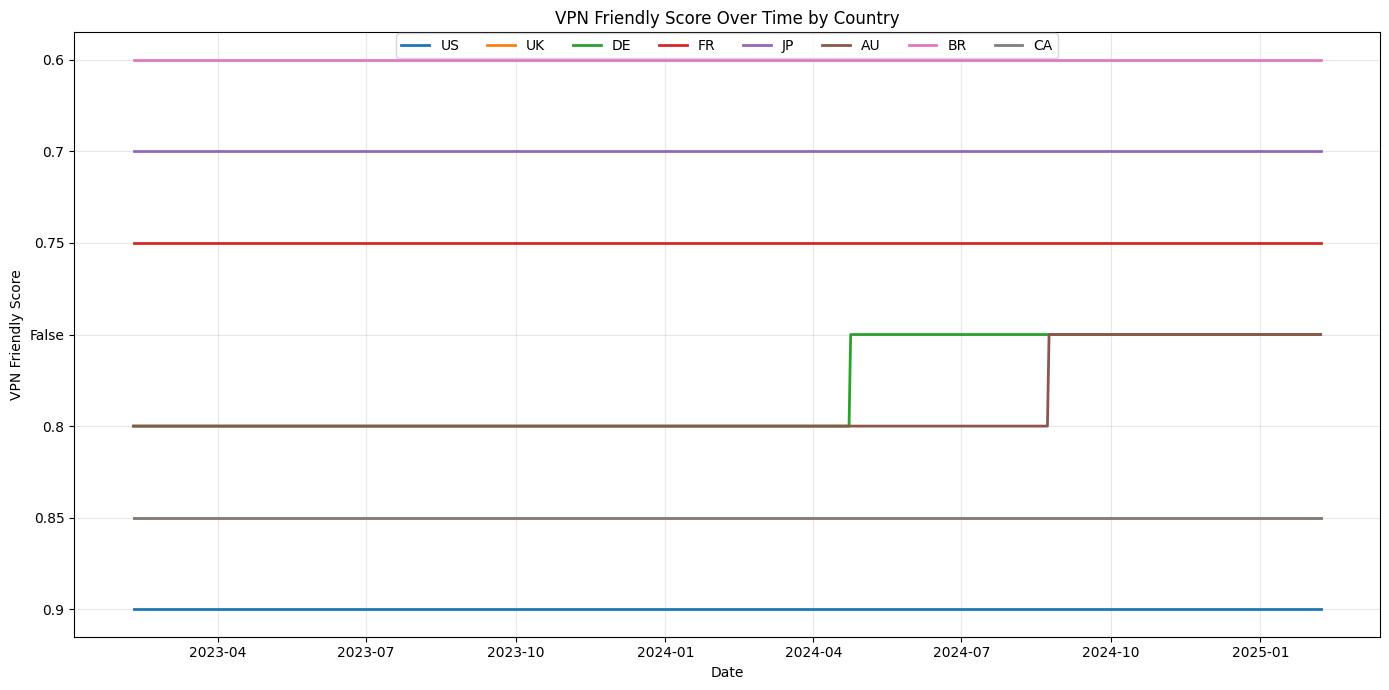

In [24]:
# Plot vpn_friendly over time for all countries
plt.figure(figsize=(14, 7))

for country in vpn_external_factors['country'].unique():
    country_data = vpn_external_factors[vpn_external_factors['country'] == country].sort_values('date')
    plt.plot(country_data['date'], country_data['vpn_friendly'], label=country, linewidth=2)

plt.xlabel('Date')
plt.ylabel('VPN Friendly Score')
plt.title('VPN Friendly Score Over Time by Country')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We notice vpn_friendly is constant except from a date where vpn_friendly is False for AU and DE countries. 

In [25]:
# Add a binary column indicating if vpn_friendly is 'False' or not
vpn_external_factors['vpn_friendly_drop'] = np.where(vpn_external_factors['vpn_friendly'] == 'False', 1, 0)

In [26]:
# Find the start date of 'False' values
vpn_external_factors[vpn_external_factors['vpn_friendly'] == 'False'].groupby('country')['date'].min()

country
AU   2024-08-24
DE   2024-04-24
Name: date, dtype: datetime64[ns]

### Merge vpn_external_factors and vpn_events 

In [27]:
# Merge to events data to see if there is any event matching the date
vpn_external_data = vpn_external_factors.merge(
    vpn_events,
    on=['country', 'date'],
    how='left'
)
vpn_external_data.head()

,date,country,vpn_friendly,internet_freedom_index,remote_work_adoption,employment_rate,vpn_friendly_drop,event_type,description,impact_score
0,2023-02-08,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN
1,2023-02-09,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN
2,2023-02-10,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN
3,2023-02-11,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN
4,2023-02-12,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN


### vpn_friendly with vpn_external_data

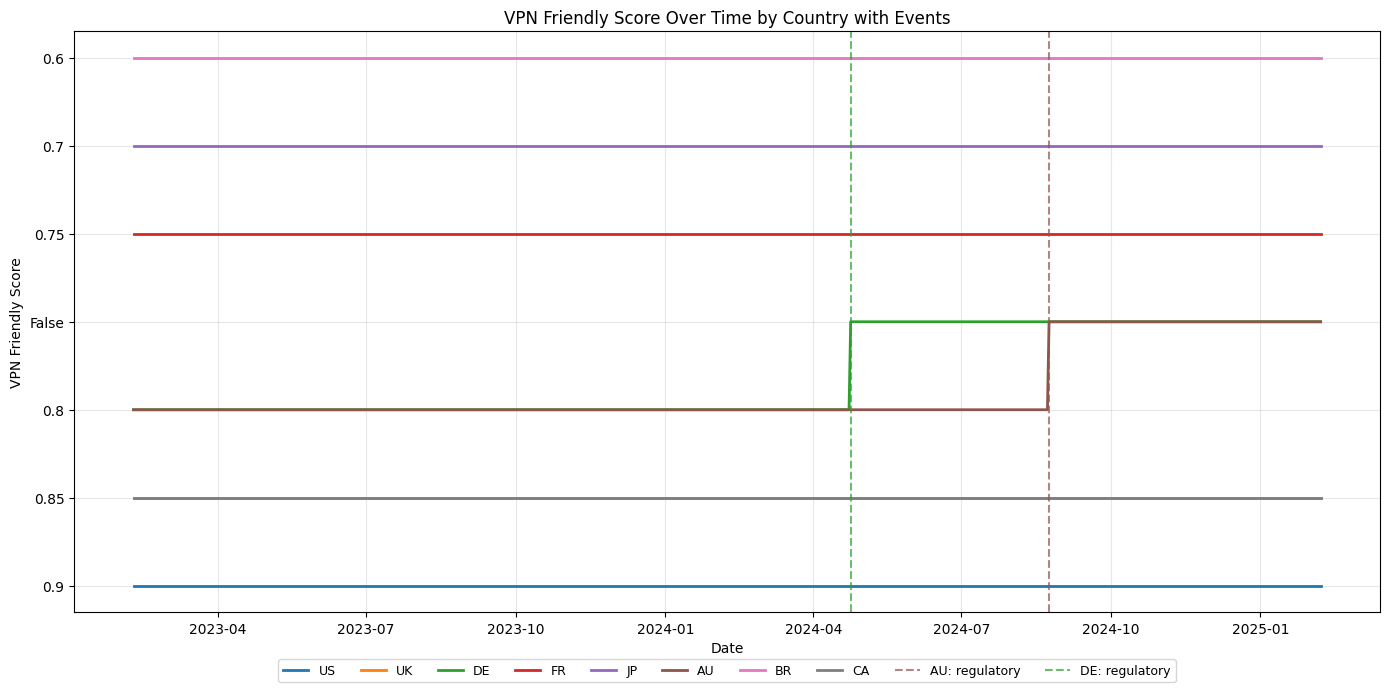

In [28]:
# Plot vpn_friendly over time for all countries with events
plt.figure(figsize=(14, 7))

# Plot vpn_friendly lines for each country
for country in vpn_external_data['country'].unique():
    country_data = vpn_external_data[vpn_external_data['country'] == country].sort_values('date')
    plt.plot(country_data['date'], country_data['vpn_friendly'], label=country, linewidth=2)

# Add vertical lines for the specific event dates we identified earlier
drop_dates = vpn_external_data[vpn_external_data['vpn_friendly_drop'] == 1].groupby('country')['date'].min()

# Add vertical lines for each country's drop date
for country, drop_date in drop_dates.items():
    event_type = vpn_external_data[(vpn_external_data['country'] == country) & (vpn_external_data['date'] == drop_date)]['event_type'].values[0]
    
    # Get the line color for this country from the already plotted lines
    country_line = [line for line in plt.gca().get_lines() if country in line.get_label()]
    if country_line:
        color = country_line[0].get_color()
    else:
        color = 'gray'
    
    plt.axvline(x=drop_date, color=color, linestyle='--', linewidth=1.5, 
               alpha=0.7, label=f'{country}: {event_type}')

plt.xlabel('Date')
plt.ylabel('VPN Friendly Score')
plt.title('VPN Friendly Score Over Time by Country with Events')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=10, fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

It matches regulatory events:
- Mandatory data retention for VPN providers in AU
- Required registration for VPN services in DE

Hence, we will replace "False" with the numeric value of 0.

In [29]:
# Replace 'False' with 0 and convert to float
vpn_external_data['vpn_friendly'] = vpn_external_data['vpn_friendly'].replace('False', '0').astype(float)

### General

In [30]:
vpn_external_data.describe(include='all')

,date,country,vpn_friendly,internet_freedom_index,remote_work_adoption,employment_rate,vpn_friendly_drop,event_type,description,impact_score
count,5848,5848,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,14,14,14.000000
unique,NaN,8,NaN,NaN,NaN,NaN,NaN,3,13,NaN
top,NaN,US,NaN,NaN,NaN,NaN,NaN,employment,Major industry changes affecting employment in US,NaN
freq,NaN,731,NaN,NaN,NaN,NaN,NaN,6,2,NaN
mean,2024-02-08 00:00:00,NaN,0.718596,78.408174,36.000000,93.234130,0.078317,NaN,NaN,3.500000
min,2023-02-08 00:00:00,NaN,0.000000,50.000000,25.000000,86.000000,0.000000,NaN,NaN,3.000000
25%,2023-08-09 00:00:00,NaN,0.700000,75.000000,32.250000,92.000000,0.000000,NaN,NaN,3.000000
50%,2024-02-08 00:00:00,NaN,0.800000,80.000000,36.500000,94.000000,0.000000,NaN,NaN,3.500000
75%,2024-08-09 00:00:00,NaN,0.850000,83.250000,40.500000,95.000000,0.000000,NaN,NaN,4.000000
max,2025-02-07 00:00:00,NaN,0.900000,85.000000,45.000000,97.000000,1.000000,NaN,NaN,4.000000


In [31]:
vpn_external_data.head()

,date,country,vpn_friendly,internet_freedom_index,remote_work_adoption,employment_rate,vpn_friendly_drop,event_type,description,impact_score
0,2023-02-08,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN
1,2023-02-09,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN
2,2023-02-10,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN
3,2023-02-11,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN
4,2023-02-12,US,0.9,85.0,45,95.0,0,NaN,NaN,NaN


As values look constant over time per country, we will check that data is not redundant. Let's check having daily data is useful or if it's just repeating the same values.

In [32]:
# Check if values are constant for each country: number of unique values per country
result = vpn_external_data.groupby('country').agg({
    'vpn_friendly': 'nunique',
    'internet_freedom_index': 'nunique',
    'remote_work_adoption': 'nunique',
    'employment_rate': 'nunique'
}).reset_index()
result

,country,vpn_friendly,internet_freedom_index,remote_work_adoption,employment_rate
0,AU,2,91,1,1
1,BR,1,1,1,1
2,CA,1,1,1,1
3,DE,2,91,1,134
4,FR,1,1,1,181
5,JP,1,1,1,181
6,UK,1,1,1,181
7,US,1,1,1,181


We notice internet freedom index has various results for both AU and DE that had a vpn_friendly drop.

We also notice various rate for employment_rate.

Let's see what is happening.

### employment_rate

In [33]:
# Find all employment rate drop periods for each country
employment_drop_data = []

for country in vpn_external_data['country'].unique():
    country_data = vpn_external_data[vpn_external_data['country'] == country].sort_values('date')

    # Only process countries with varying employment rates
    if country_data['employment_rate'].nunique() > 1:
        min_rate = country_data['employment_rate'].min()
        max_rate = country_data['employment_rate'].max()
        
        # Get all dates where rate is at minimum
        drop_dates = country_data[country_data['employment_rate'] == min_rate]['date'].tolist()
        
        # Get all dates where rate is at maximum
        recovery_dates = country_data[country_data['employment_rate'] == max_rate]['date'].tolist()
        
        # Create a row for each drop period
        for i, drop_date in enumerate(drop_dates, 1):
            # Find the next recovery date after this drop
            recovery_date = next((d for d in recovery_dates if d > drop_date), None)
            
            employment_drop_data.append({
                'country': country,
                'drop_number': i,
                'drop_start_date': drop_date,
                'drop_end_date': recovery_date
            })

# Create DataFrame
employment_drops_df = pd.DataFrame(employment_drop_data)
employment_drops_df

,country,drop_number,drop_start_date,drop_end_date
0,US,1,2023-10-14,2024-04-11
1,US,2,2024-09-28,NaT
2,UK,1,2023-06-02,2023-11-29
3,DE,1,2024-09-28,NaT
4,FR,1,2023-10-14,2024-04-11
5,JP,1,2023-10-14,2024-04-11


In [34]:
# Merge employment_drops_df to vpn_external_data to mark drop periods
vpn_external_data['employment_drop'] = 0

for index, drop in employment_drops_df.iterrows():
    mask = (
        (vpn_external_data['country'] == drop['country']) &
        (vpn_external_data['date'] >= drop['drop_start_date']) &
        (vpn_external_data['date'] <= drop['drop_end_date'])
    )
    vpn_external_data.loc[mask, 'employment_drop'] = 1

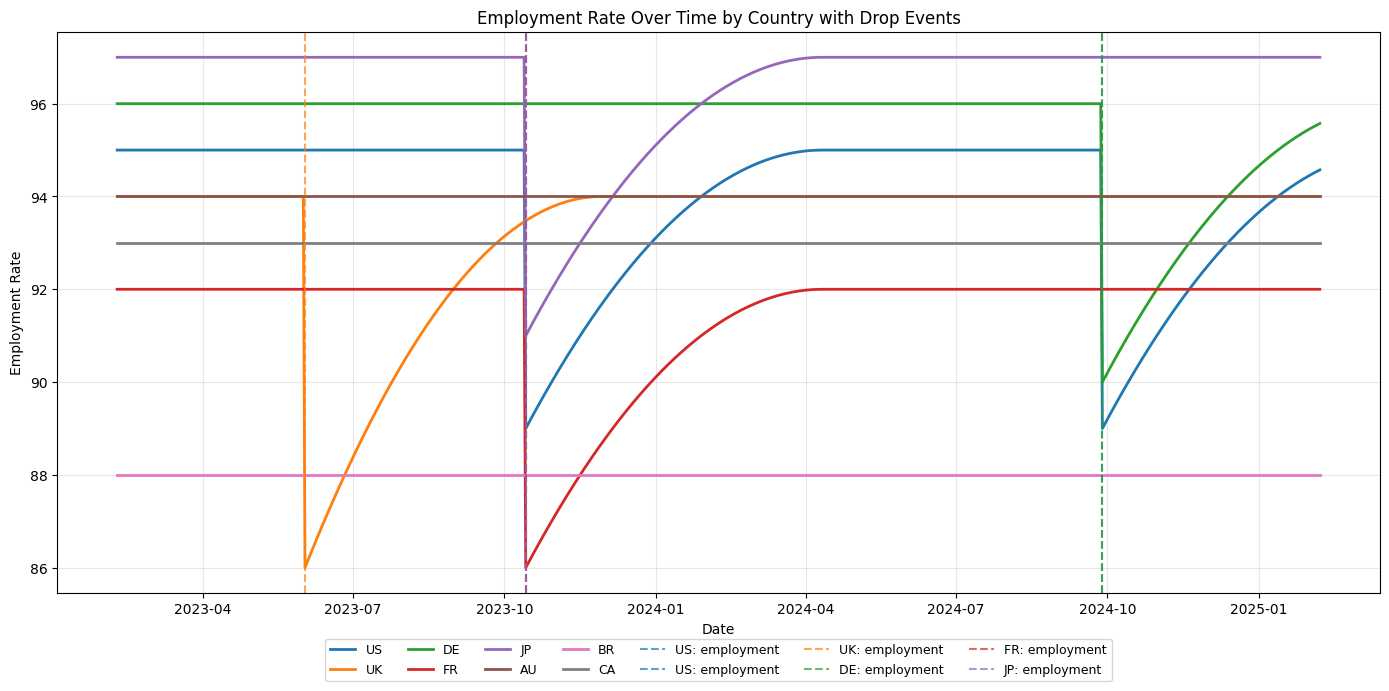

In [35]:
# Plot employment_rate over time for all countries with employment drop events
plt.figure(figsize=(14, 7))

# Plot employment_rate lines for each country
for country in vpn_external_data['country'].unique():
    country_data = vpn_external_data[vpn_external_data['country'] == country].sort_values('date')
    plt.plot(country_data['date'], country_data['employment_rate'], label=country, linewidth=2)

# Add vertical lines for employment drop dates using employment_drops_df
for index, drop in employment_drops_df.iterrows():
    country = drop['country']
    drop_date = drop['drop_start_date']
    
    # Check if there's a matching event on this date
    matching_event = vpn_external_data[(vpn_external_data['country'] == country) & 
                                       (vpn_external_data['date'] == drop_date)]['event_type'].values
    
    if len(matching_event) > 0:
        label_text = f'{country}: {matching_event[0]}'
    else:
        label_text = f'{country}: Employment Drop'
    
    # Get the line color for this country from the already plotted lines
    country_line = [line for line in plt.gca().get_lines() if country in line.get_label()]
    if country_line:
        color = country_line[0].get_color()
    else:
        color = 'gray'
    
    plt.axvline(x=drop_date, color=color, linestyle='--', linewidth=1.5, 
               alpha=0.7, label=label_text)

plt.xlabel('Date')
plt.ylabel('Employment Rate')
plt.title('Employment Rate Over Time by Country with Drop Events')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=7, fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We notice employment rate is dropping before coming back to previous rate and match with major industry changes events or layoffs.

### internet_freedom_index

In [36]:
# Find all internet freedom index drop periods for each country
internet_freedom_index_drop_data = []

for country in vpn_external_data['country'].unique():
    country_data = vpn_external_data[vpn_external_data['country'] == country].sort_values('date')

    # Only process countries with varying internet freedom index
    if country_data['internet_freedom_index'].nunique() > 1:
        min_index = country_data['internet_freedom_index'].min()
        max_index = country_data['internet_freedom_index'].max()

        # Get all dates where index is at minimum
        drop_dates = country_data[country_data['internet_freedom_index'] == min_index]['date'].tolist()

        # Get all dates where index is at maximum
        recovery_dates = country_data[country_data['internet_freedom_index'] == max_index]['date'].tolist()

    if country_data['internet_freedom_index'].nunique() > 1:
        min_index = country_data['internet_freedom_index'].min()
        max_index = country_data['internet_freedom_index'].max()

        # Get all dates where index is at minimum
        drop_dates = country_data[country_data['internet_freedom_index'] == min_index]['date'].tolist()

        # Get all dates where index is at maximum
        recovery_dates = country_data[country_data['internet_freedom_index'] == max_index]['date'].tolist()

        # Create a row for each drop period
        for i, drop_date in enumerate(drop_dates, 1):
            # Find the next recovery date after this drop
            recovery_date = next((d for d in recovery_dates if d > drop_date), None)
            
            internet_freedom_index_drop_data.append({
                'country': country,
                'drop_number': i,
                'drop_start_date': drop_date,
                'drop_end_date': recovery_date
            })

# Create DataFrame
internet_freedom_index_drops_df = pd.DataFrame(internet_freedom_index_drop_data)
internet_freedom_index_drops_df

,country,drop_number,drop_start_date,drop_end_date
0,DE,1,2024-04-24,2024-07-23
1,AU,1,2024-08-24,2024-11-22


In [37]:
# Merge employment_drops_df to vpn_external_factors to mark drop periods
vpn_external_data['internet_freedom_index_drop'] = 0

for index, drop in internet_freedom_index_drops_df.iterrows():
    mask = (
        (vpn_external_data['country'] == drop['country']) &
        (vpn_external_data['date'] >= drop['drop_start_date']) &
        (vpn_external_data['date'] <= drop['drop_end_date'])
    )
    vpn_external_data.loc[mask, 'internet_freedom_index_drop'] = 1

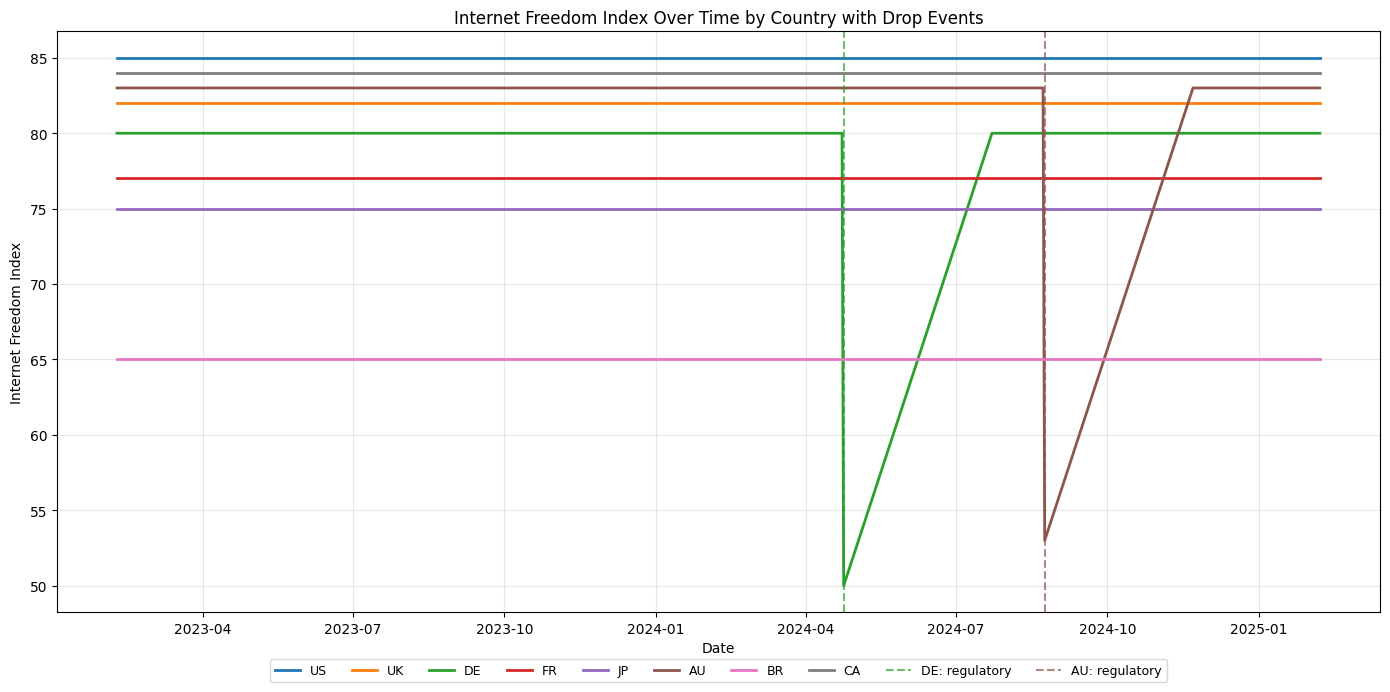

In [38]:
# Plot internet_freedom_index over time for all countries with drop events
plt.figure(figsize=(14, 7))

# Plot internet_freedom_index lines for each country
for country in vpn_external_data['country'].unique():
    country_data = vpn_external_data[vpn_external_data['country'] == country].sort_values('date')
    plt.plot(country_data['date'], country_data['internet_freedom_index'], label=country, linewidth=2)

# Add vertical lines for internet freedom index drop dates using internet_freedom_index_drops_df
for index, drop in internet_freedom_index_drops_df.iterrows():
    country = drop['country']
    drop_date = drop['drop_start_date']
    
    # Check if there's a matching event on this date
    matching_event = vpn_external_data[(vpn_external_data['country'] == country) & 
                                       (vpn_external_data['date'] == drop_date)]['event_type'].values
    
    if len(matching_event) > 0:
        label_text = f'{country}: {matching_event[0]}'
    else:
        label_text = f'{country}: Internet Freedom Drop'
    
    # Get the line color for this country from the already plotted lines
    country_line = [line for line in plt.gca().get_lines() if country in line.get_label()]
    if country_line:
        color = country_line[0].get_color()
    else:
        color = 'gray'
    
    plt.axvline(x=drop_date, color=color, linestyle='--', linewidth=1.5, 
               alpha=0.7, label=label_text)

plt.xlabel('Date')
plt.ylabel('Internet Freedom Index')
plt.title('Internet Freedom Index Over Time by Country with Drop Events')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=10, fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Regulatory events have an influence on Internet Freedom Index, and vpn friendly scores.
- AU and DE experiences regulatory crackdowns that reduced vpn friendly scores and internet freedom index
Employement events have an influence on employment rate.
- employment events have a temporary pattern as rates go back to baseline afterwards
Remote work adoption is constant

# Create a unified data frame

Merging the datasets into a unified dataframe will facilitate the analysis by allowing us to correlate external factors with customer behavior and churn patterns more effectively, while also simplifying data visualization.

We will merge vpn_external_data to vpn_customer_data.  

In [39]:
vpn_data = vpn_customer_data.merge(
    vpn_external_data,
    left_on=['signup_country', 'signup_date'],
    right_on=['country', 'date'],
    how='left'
).drop(columns=['country', 'date'])

In [40]:
vpn_data.head()

,user_id,signup_date,signup_country,churn_date,plan,plan_price,monthly_usage_hours,countries_connected_to,num_tickets,churned,num_devices,num_distinct_devices,devices_desktop,devices_mobile,devices_smart-tv,devices_tablet,support_tickets_account,support_tickets_billing,support_tickets_connection,support_tickets_technical,vpn_friendly,internet_freedom_index,remote_work_adoption,employment_rate,vpn_friendly_drop,event_type,description,impact_score,employment_drop,internet_freedom_index_drop
0,1,2023-05-25,DE,2023-09-22,monthly,9.99,69,10,1,1,1,1,0,1,0,0,1,0,0,0,0.80,80.0,35,96.000000,0,NaN,NaN,NaN,0,0
1,2,2023-06-23,US,2024-11-14,monthly,9.99,197,5,2,1,3,3,0,1,1,1,1,0,0,1,0.90,85.0,45,95.000000,0,NaN,NaN,NaN,0,0
2,3,2023-04-27,US,2023-11-23,monthly,9.99,107,6,1,1,4,2,1,0,0,3,0,1,0,0,0.90,85.0,45,95.000000,0,NaN,NaN,NaN,0,0
3,4,2023-08-24,FR,2024-10-17,monthly,9.99,120,6,2,1,3,2,0,1,2,0,0,0,0,2,0.75,77.0,33,92.000000,0,NaN,NaN,NaN,0,0
4,5,2024-03-18,US,2024-11-13,monthly,9.99,121,5,2,1,2,1,0,0,2,0,2,0,0,0,0.90,85.0,45,94.893333,0,NaN,NaN,NaN,1,0


# Analysis

## 1. Exploratory analysis to understand the data

### 1.1 Overall churn rate and trends over time

In [41]:
# Calculate overall churn rate
overall_churn_rate = 100 * vpn_data['churned'].mean()

print(f"Overall Churn Rate: {overall_churn_rate:.2f}%")
print(f"Total Customers: {len(vpn_data)}")
print(f"Churned Customers: {vpn_data['churned'].sum()}")
print(f"Retained Customers: {(vpn_data['churned'] == 0).sum()}")

Overall Churn Rate: 40.04%
Total Customers: 100000
Churned Customers: 40043
Retained Customers: 59957


In [42]:
# Churn over time by signup month
vpn_data['signup_month'] = vpn_data['signup_date'].dt.to_period('M')

churn_by_month = vpn_data.groupby('signup_month').agg({'churned': 'mean'}).reset_index()
churn_by_month.columns = ['signup_month', 'churn_rate']
churn_by_month['churn_rate'] = churn_by_month['churn_rate'] * 100

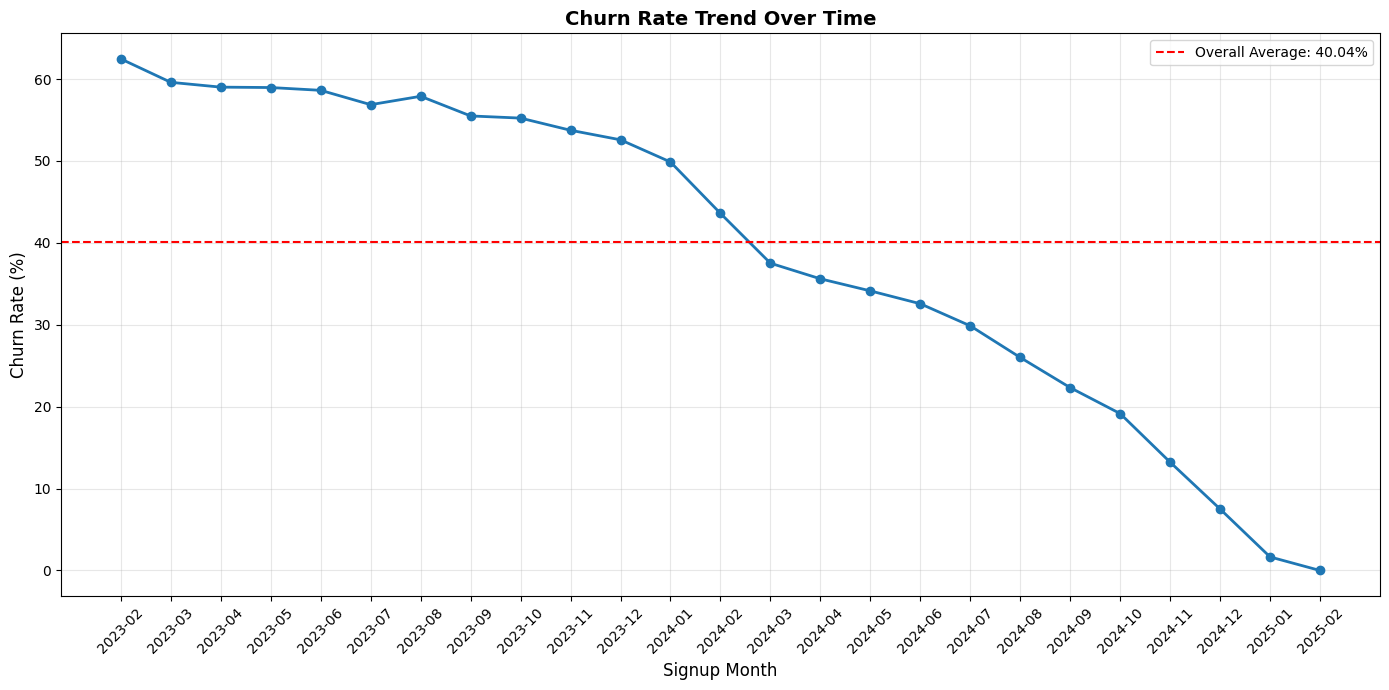

In [43]:
# Plot churn rate over time
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(churn_by_month['signup_month'].astype(str), churn_by_month['churn_rate'], 
        marker='o', linewidth=2, markersize=6)

# Average churn rate line
ax.axhline(y=overall_churn_rate, color='red', linestyle='--',label=f'Overall Average: {overall_churn_rate:.2f}%')
ax.set_xlabel('Signup Month', fontsize=12)
ax.set_ylabel('Churn Rate (%)', fontsize=12)
ax.set_title('Churn Rate Trend Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We notice that the churn rate decreases overall over time. This is consistent, the longer the customer has been with us, the higher the churn rate.

### 1.2 Customer segment breakdown (plan types, countries, devices)

#### 1.2.1 Plan distribution

In [44]:
# Plan Type Distribution
plan_breakdown = vpn_data.groupby('plan').agg({
    'user_id': 'count',
    'churned': 'mean'
}).reset_index()

plan_breakdown.columns = ['plan', 'total_customers', 'churn_rate']
plan_breakdown['churn_rate'] = plan_breakdown['churn_rate'] * 100

total = plan_breakdown['total_customers'].sum()

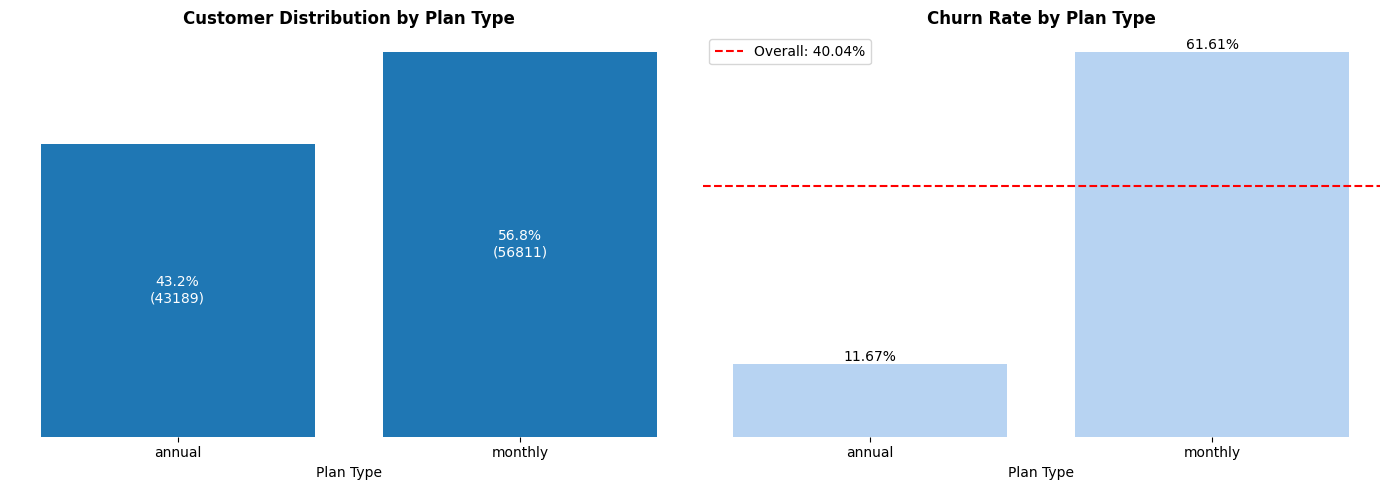

In [45]:
# Visualize plan distribution and churn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plan distribution
bars = axes[0].bar(plan_breakdown['plan'], plan_breakdown['total_customers'])
axes[0].set_title('Customer Distribution by Plan Type', fontweight='bold')
axes[0].set_xlabel('Plan Type')

# Add count and percentage using bar_label (inside bars, white color)
labels = [f'{count/total*100:.1f}%\n({int(count)})' for count in plan_breakdown['total_customers']]
axes[0].bar_label(bars, labels=labels, label_type='center', color='white')

# Churn rate by plan
bars2 = axes[1].bar(plan_breakdown['plan'], plan_breakdown['churn_rate'], color='#B7D3F2')
axes[1].set_title('Churn Rate by Plan Type', fontweight='bold')
axes[1].set_xlabel('Plan Type')

# Add overall churn rate line
axes[1].axhline(y=overall_churn_rate, color='red', linestyle='--', label=f'Overall: {overall_churn_rate:.2f}%')
axes[1].legend()

# Add percentage using bar_label
axes[1].bar_label(bars2, labels=[f'{rate:.2f}%' for rate in plan_breakdown['churn_rate']])

# Clean up both axes
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

As expected, monthly plan customers are more likely to churn.

#### 1.2.2 Country distribution

In [46]:
# Country Distribution
country_breakdown = vpn_data.groupby('signup_country').agg({
    'user_id': 'count',
    'churned': 'mean'
}).reset_index()

country_breakdown.columns = ['country', 'total_customers', 'churn_rate']
country_breakdown['churn_rate'] = country_breakdown['churn_rate'] * 100
country_breakdown = country_breakdown.sort_values('total_customers', ascending=False)

total_country = country_breakdown['total_customers'].sum()

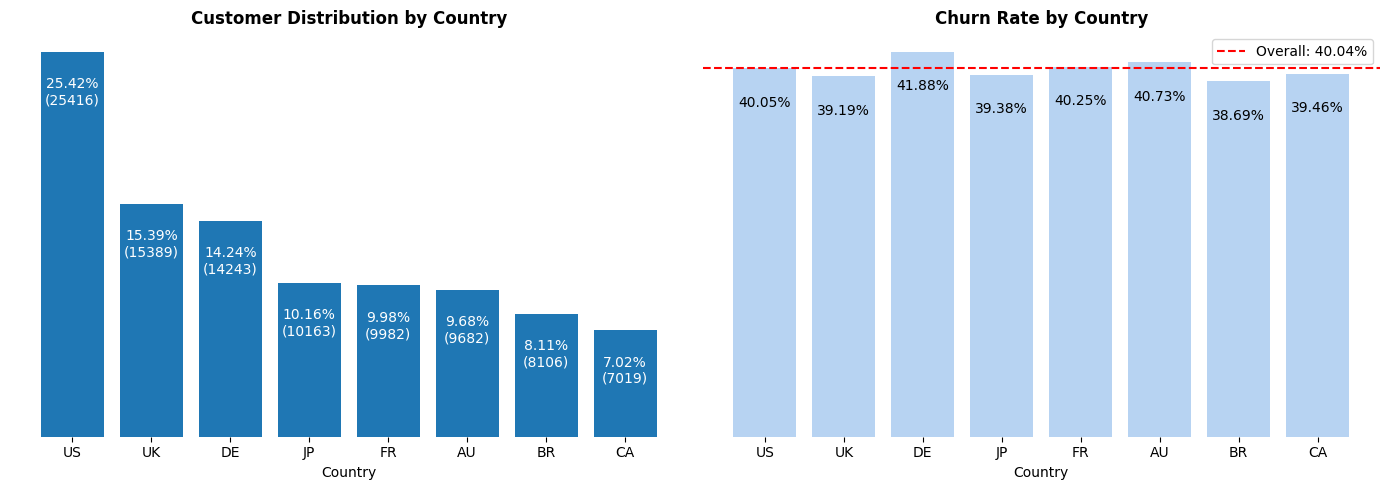

In [47]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top countries by customer count
bars1 = axes[0].bar(country_breakdown['country'], country_breakdown['total_customers'])
axes[0].set_title('Customer Distribution by Country', fontweight='bold')
axes[0].set_xlabel('Country')

# Add count and percentage using bar_label (inside bars, white color)
labels = [f'{count/total_country*100:.2f}%\n({int(count)})' for count in country_breakdown['total_customers']]
axes[0].bar_label(bars1, labels=labels, label_type='edge', padding=-40, color='white')

# Churn rate by country
bars2 = axes[1].bar(country_breakdown['country'], country_breakdown['churn_rate'], color='#B7D3F2')
axes[1].set_title('Churn Rate by Country', fontweight='bold')
axes[1].set_xlabel('Country')

# Add overall churn rate line
axes[1].axhline(y=overall_churn_rate, color='red', linestyle='--', label=f'Overall: {overall_churn_rate:.2f}%')
axes[1].legend()

# Add percentage using bar_label
axes[1].bar_label(bars2, labels=[f'{rate:.2f}%' for rate in country_breakdown['churn_rate']], label_type='edge', padding=-30)

# Clean up both axes
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

We notice a higher number of customers from the US. 
However, the churn rate is on average higher for DE and AU, and slightly over for FR and US.
We can remember that we saw previously an internet_freedom_index drop for both DE and AU due to regulatory events.

#### 1.2.3 Device distribution

In [48]:
# Device Distribution
device_cols = vpn_data.filter(regex='^devices_').columns

device_breakdown = []
for device in device_cols:
    device_name = device.replace('devices_', '')
    # Get users who used this device (value > 0)
    users_with_device = vpn_data[vpn_data[device] > 0]
    
    device_breakdown.append({
        'device': device_name,
        'total_customers': len(users_with_device),
        'churn_rate': users_with_device['churned'].mean() * 100
    })

device_breakdown = pd.DataFrame(device_breakdown).sort_values('total_customers', ascending=False)
device_breakdown

total_device = device_breakdown['total_customers'].sum()

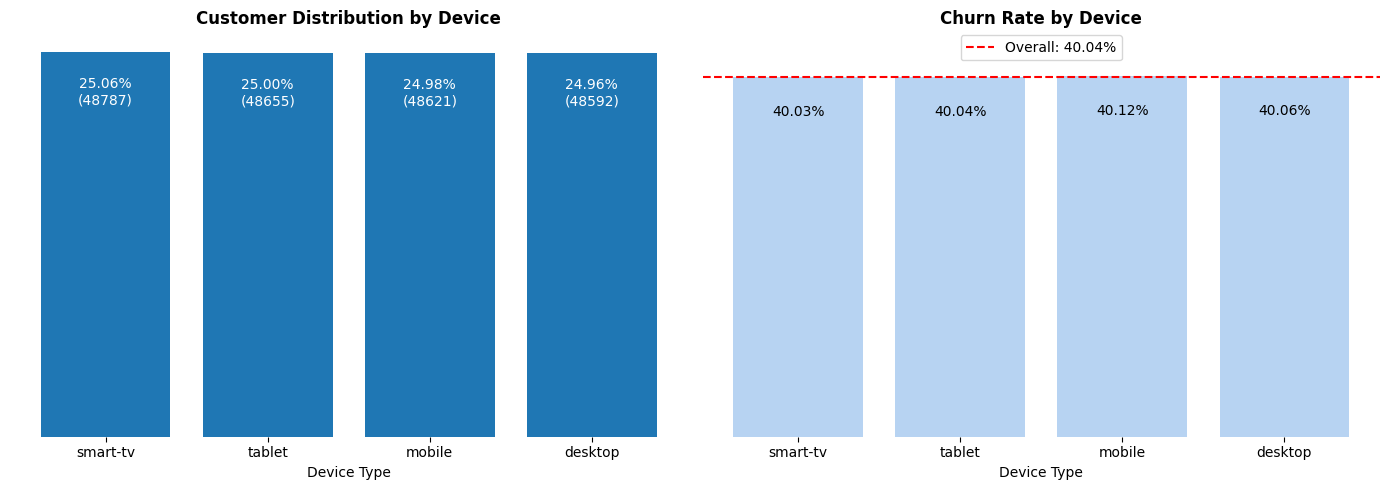

In [49]:
# Visualize device distribution and churn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Device distribution
bars1 = axes[0].bar(device_breakdown['device'], device_breakdown['total_customers'])
axes[0].set_title('Customer Distribution by Device', fontweight='bold')
axes[0].set_xlabel('Device Type')

# Add count and percentage using bar_label (inside bars, white color)
labels = [f'{count/total_device*100:.2f}%\n({int(count)})' for count in device_breakdown['total_customers']]
axes[0].bar_label(bars1, labels=labels, label_type='edge', padding=-40, color='white')

# Churn rate by device
bars2 = axes[1].bar(device_breakdown['device'], device_breakdown['churn_rate'], color='#B7D3F2')
axes[1].set_title('Churn Rate by Device', fontweight='bold')
axes[1].set_xlabel('Device Type')
axes[1].set_ylim(0, 45)  # Set y-axis limit to 45% to add more space

# Add overall churn rate line
axes[1].axhline(y=overall_churn_rate, color='red', linestyle='--', label=f'Overall: {overall_churn_rate:.2f}%')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.01))


# Add percentage using bar_label
axes[1].bar_label(bars2, labels=[f'{rate:.2f}%' for rate in device_breakdown['churn_rate']], label_type='edge', padding=-30)

# Clean up both axes
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

Distribution across devices is homogeneous.

### 1.3 Usage Patterns Distribution

#### 1.3.1 Monthly usage hour distribution

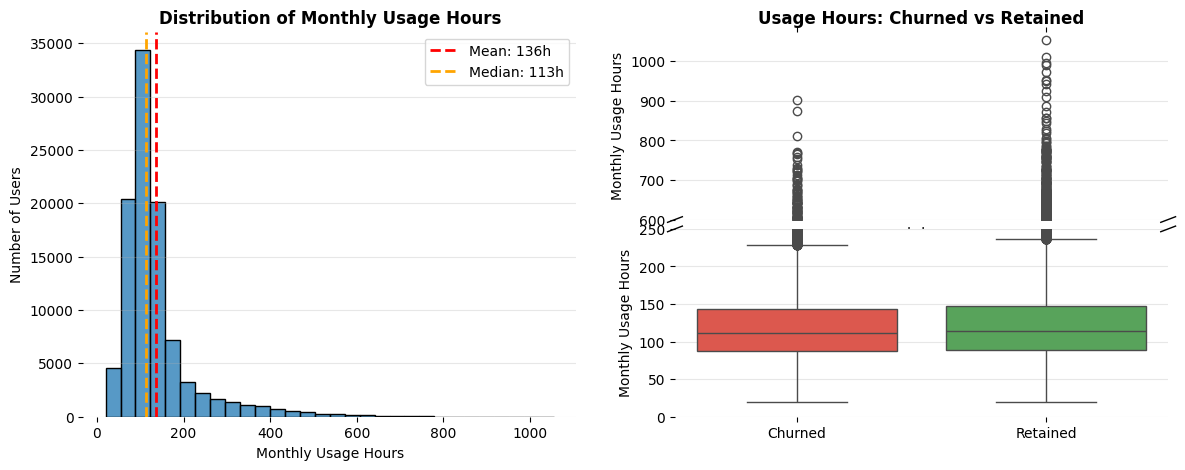

In [50]:
# Monthly usage hours distribution with broken axis
fig = plt.figure(figsize=(14, 5))

# Create grid for histogram and two boxplot axes
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.05)
ax_hist = fig.add_subplot(gs[:, 0])  # Histogram spans both rows
ax_box1 = fig.add_subplot(gs[0, 1])  # Top boxplot (outliers)
ax_box2 = fig.add_subplot(gs[1, 1])  # Bottom boxplot (main data)

# Histogram
sns.histplot(data=vpn_data, x='monthly_usage_hours', bins=30, ax=ax_hist, edgecolor='black')
ax_hist.axvline(vpn_data['monthly_usage_hours'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {int(vpn_data["monthly_usage_hours"].mean())}h')
ax_hist.axvline(vpn_data['monthly_usage_hours'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {int(vpn_data["monthly_usage_hours"].median())}h')
ax_hist.set_title('Distribution of Monthly Usage Hours', fontweight='bold')
ax_hist.set_xlabel('Monthly Usage Hours')
ax_hist.set_ylabel('Number of Users')
ax_hist.legend()
ax_hist.grid(True, alpha=0.3, axis='y')

# Box plots on both axes
vpn_data['status'] = vpn_data['churned'].map({0: 'Retained', 1: 'Churned'})

sns.boxplot(data=vpn_data, x='status', y='monthly_usage_hours',
            palette={'Retained': '#4CAF50', 'Churned': '#F44336'},
            ax=ax_box1)

sns.boxplot(data=vpn_data, x='status', y='monthly_usage_hours',
            palette={'Retained': '#4CAF50', 'Churned': '#F44336'},
            ax=ax_box2)

# Set limits to create break - HIDING 250-600
ax_box1.set_ylim(600, vpn_data['monthly_usage_hours'].max() + 20)  # Outliers above 600
ax_box2.set_ylim(0, 250)  # Main distribution 0-250

# Hide spines between axes
ax_box1.spines['bottom'].set_visible(False)
ax_box2.spines['top'].set_visible(False)
ax_box1.xaxis.tick_top()
ax_box1.tick_params(labeltop=False, labelbottom=False)
ax_box2.xaxis.tick_bottom()

# Add diagonal break lines
d = .015
kwargs = dict(transform=ax_box1.transAxes, color='k', clip_on=False, linewidth=1)
ax_box1.plot((-d, +d), (-d, +d), **kwargs)
ax_box1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax_box2.transAxes)
ax_box2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax_box2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Titles
ax_box1.set_title('Usage Hours: Churned vs Retained', fontweight='bold')
ax_box1.set_ylabel('Monthly Usage Hours')
ax_box2.set_ylabel('Monthly Usage Hours')
ax_box2.set_xlabel('')

# Grid
ax_box1.grid(True, alpha=0.3, axis='y')
ax_box2.grid(True, alpha=0.3, axis='y')

# Clean up
for ax in [ax_hist, ax_box1, ax_box2]:
    for spine in ax.spines.values():
        if spine.get_visible():
            spine.set_visible(False)

plt.tight_layout()
plt.show()

In [51]:
# Boxplot statistics
usage_stats = vpn_data.groupby('status')['monthly_usage_hours'].describe().round(1)
usage_stats.loc['Difference (Retained - Churned)'] = usage_stats.loc['Retained'] - usage_stats.loc['Churned']

usage_stats = usage_stats.reset_index()
usage_stats

,status,count,mean,std,min,25%,50%,75%,max
0,Churned,40043.0,131.8,80.3,20.0,88.0,112.0,144.0,903.0
1,Retained,59957.0,139.0,93.9,20.0,89.0,114.0,148.0,1055.0
2,Difference (Retained - Churned),19914.0,7.2,13.6,0.0,1.0,2.0,4.0,152.0


We notice a right-skewed distribution with mean > median, indicating the presence of high-usage outliers. Most users use the VPN moderately, around 150h per month.

Regarding information we get from the boxplot:
- The median difference between Retained and Churned customers is only 2 hours.
- Both groups have power users which means that high usage alone does not prevent churn.
- The IQR interquartile range overlaps significantly between groups.

Monthly usage hours show minimal predictive power for churn. Power users can and do churn, suggesting that usage volume alone is not a retention driver. 

We need to look beyond simple usage metrics.

#### 1.3.2 Countries connected to distribution

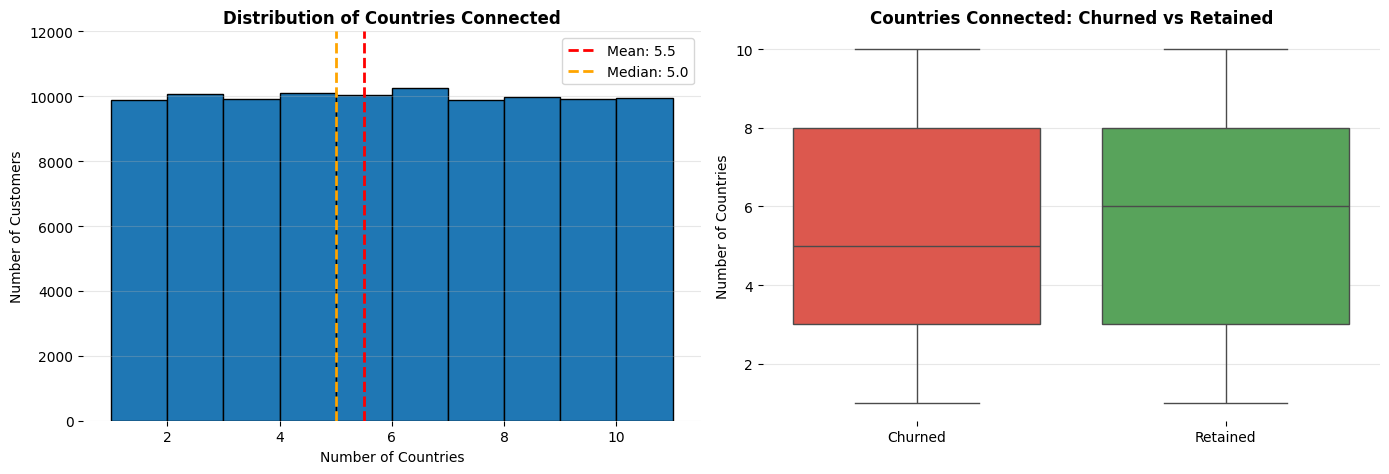

In [52]:
# Countries connected to distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(vpn_data['countries_connected_to'], bins=range(1, 12), edgecolor='black')
axes[0].axvline(vpn_data['countries_connected_to'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {vpn_data["countries_connected_to"].mean():.1f}')
axes[0].axvline(vpn_data['countries_connected_to'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {vpn_data["countries_connected_to"].median():.1f}')
axes[0].set_title('Distribution of Countries Connected', fontweight='bold')
axes[0].set_xlabel('Number of Countries')
axes[0].set_ylabel('Number of Customers')
axes[0].set_ylim(0, 12000)  # Set y-axis limit to add more space
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot: Churned vs Retained using seaborn with status mapping
vpn_data['status'] = vpn_data['churned'].map({0: 'Retained', 1: 'Churned'})

sns.boxplot(data=vpn_data, x='status', y='countries_connected_to',
            palette={'Retained': '#4CAF50', 'Churned': '#F44336'},
            ax=axes[1])

axes[1].set_title('Countries Connected: Churned vs Retained', fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Number of Countries')
axes[1].grid(True, alpha=0.3, axis='y')

# Remove suptitle
plt.suptitle('')

# Clean up spines
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

The median shows that typical churned customers use the VPN less than typical retained customers but nothing outstanding.

#### 1.3.3 Number of distinct devices distribution

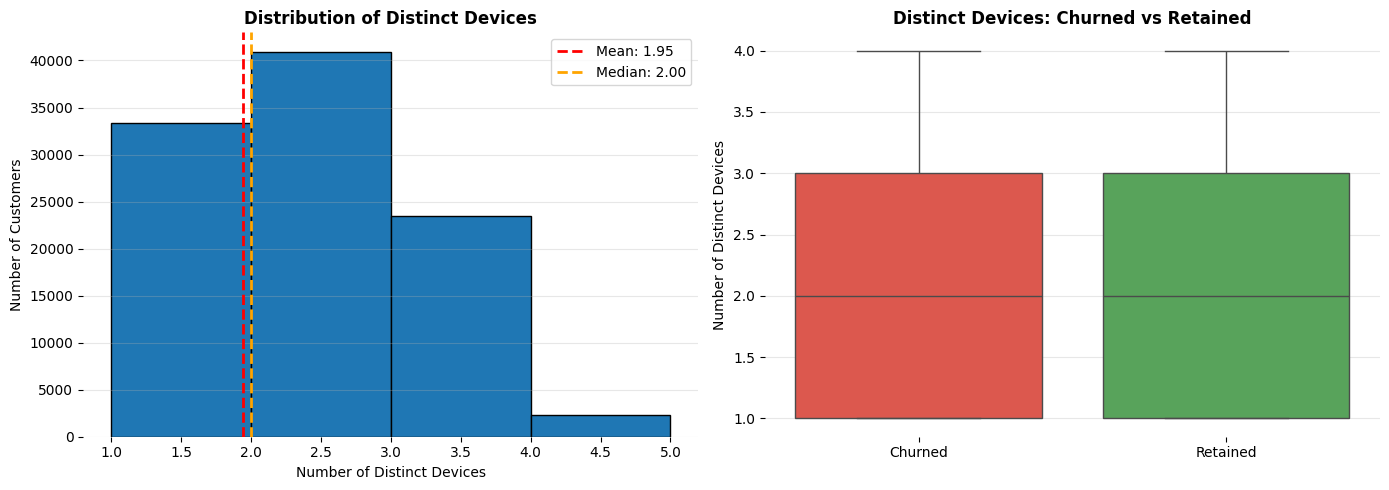

In [53]:
# Number of distinct devices distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(vpn_data['num_distinct_devices'], bins=range(1, 6), edgecolor='black')
axes[0].axvline(vpn_data['num_distinct_devices'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {vpn_data["num_distinct_devices"].mean():.2f}')
axes[0].axvline(vpn_data['num_distinct_devices'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {vpn_data["num_distinct_devices"].median():.2f}')
axes[0].set_title('Distribution of Distinct Devices', fontweight='bold')
axes[0].set_xlabel('Number of Distinct Devices')
axes[0].set_ylabel('Number of Customers')

axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot: Churned vs Retained using seaborn with status mapping
vpn_data['status'] = vpn_data['churned'].map({0: 'Retained', 1: 'Churned'})

sns.boxplot(data=vpn_data, x='status', y='num_distinct_devices',
            palette={'Retained': '#4CAF50', 'Churned': '#F44336'},
            ax=axes[1])

axes[1].set_title('Distinct Devices: Churned vs Retained', fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Number of Distinct Devices')
axes[1].grid(True, alpha=0.3, axis='y')

# Clean up spines
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

We observe a consistent behavior across the customer base. Most customers use 2 distinct devices

The boxplots show no visual difference between churned and retained customers.

Number of distinct devices shows weak predictive power for churn. Using 1 device vs 4 devices doesn't meaningfully differentiate between customers who stay vs leave. 

Device diversity alone is not a strong retention indicator. The hypothesis that "more devices = more sticky customers" is not strongly supported by the data. We should focus on other factors.

## 2. Churn pattern identification

In [54]:
# Initialize a list to store all test results at the beginning of your analysis section
test_results = []

### 2.1 Plan-Based Churn: Monthly vs Annual plans
Hypothesis: Monthly plans have higher churn

In [55]:
# Statistical Test:  we're testing the relationship between two categorical variables so we use the Chi-square test
# H0: Plan type and churn are independent
# H1: Plan type and churn are related

contingency_table = pd.crosstab(vpn_data['plan'], vpn_data['churned'])
chi2, p_value = stats.chi2_contingency(contingency_table)[:2]

print("Chi-Square Test Results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nConclusion: {'REJECT' if p_value < 0.05 else 'FAIL TO REJECT'} null hypothesis")
print(f"Plan type {'IS' if p_value < 0.05 else 'IS NOT'} significantly associated with churn.")

# How strong is the relationship ? Calculate effect size (Cramér's V)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / n)
print(f"\nEffect strength: {'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'}")

test_results.append({
    'Variable': 'Plan Type',
    'Test': 'Chi-square',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cramér's V: {cramers_v:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'
})

Chi-Square Test Results:
Chi-square statistic: 25485.2841
P-value: 0.0000

Conclusion: REJECT null hypothesis
Plan type IS significantly associated with churn.

Effect strength: Large


**Key Findings:**

Over half of monthly subscribers churn vs less than a quarter of yearly subscribers. **Monthly plans have significantly higher churn**. 

**Monthly plans are a strong predictor of churn risk.**

### 2.2 Usage-Based Churn Analysis
Hypothesis: Low usage predicts churn. We previously saw that Mmnthly usage hours show minimal predictive power for churn.

In [56]:
# Statistical Test: we're testing if usage hours differ between churned vs retained. As this is a continuous variable, we use a t-test
# H0: Mean usage hours are equal between churned and retained customers
# H1: Mean usage hours differ between groups

churned_usage = vpn_data[vpn_data['churned'] == 1]['monthly_usage_hours']
retained_usage = vpn_data[vpn_data['churned'] == 0]['monthly_usage_hours']

t_stat, p_value = stats.ttest_ind(retained_usage, churned_usage)

print("Independent T-Test Results:")
print(f"Mean usage (Retained): {retained_usage.mean():.2f} hours")
print(f"Mean usage (Churned): {churned_usage.mean():.2f} hours")
print(f"Difference: {retained_usage.mean() - churned_usage.mean():.2f} hours")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"\nConclusion: {'REJECT' if p_value < 0.05 else 'FAIL TO REJECT'} null hypothesis")
print(f"Usage hours {'DO' if p_value < 0.05 else 'DO NOT'} significantly differ between groups.")

# Calculate Cohen's d to know if the difference is practically meaningful, not just statistically significant.
# < 0.2: Negligible / 0.2-0.5: Small / 0.5-0.8: Medium / 0.8: Large
cohens_d = (retained_usage.mean() - churned_usage.mean()) / np.sqrt(
    ((len(retained_usage)-1)*retained_usage.std()**2 + (len(churned_usage)-1)*churned_usage.std()**2) / 
    (len(retained_usage) + len(churned_usage) - 2)
)
print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
print(f"Effect strength: {'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'}")

test_results.append({
    'Variable': 'Monthly Usage Hours',
    'Test': 'T-test',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cohen's d: {cohens_d:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'
})

Independent T-Test Results:
Mean usage (Retained): 139.02 hours
Mean usage (Churned): 131.76 hours
Difference: 7.26 hours

T-statistic: 12.6810
P-value: 8.0475e-37

Conclusion: REJECT null hypothesis
Usage hours DO significantly differ between groups.

Effect Size (Cohen's d): 0.0818
Effect strength: Negligible


**Key Findings:**

We notice a 7hour difference that is real and not random chance. But the difference is so small it doesn't matter in practice. 7 hours/month is only 14 minutes per day...

While retained customers statistically use more hours, the effect is negligible. The 7-hour monthly difference is too small to be a meaningful churn predictor.

**Usage hours are not an actionnable predictor of churn risk.**

### 2.3 Device Churn
Hypothesis: The more device used the less churn

In [57]:
# Statistical Test: T-test for number of distinct devices
# H0: Mean number of devices is equal between churned and retained customers
# H1: Mean number of devices differs between groups

churned_devices = vpn_data[vpn_data['churned'] == 1]['num_distinct_devices']
retained_devices = vpn_data[vpn_data['churned'] == 0]['num_distinct_devices']

t_stat, p_value = stats.ttest_ind(retained_devices, churned_devices)

print("T-Test Results - Number of Distinct Devices:")
print(f"Mean devices (Retained): {retained_devices.mean():.2f}")
print(f"Mean devices (Churned): {churned_devices.mean():.2f}")
print(f"Difference: {retained_devices.mean() - churned_devices.mean():.2f}")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nConclusion: {'REJECT' if p_value < 0.05 else 'FAIL TO REJECT'} null hypothesis")
print(f"Device diversity {'DOES' if p_value < 0.05 else 'DOES NOT'} significantly differ between groups.")

# Effect size (Cohen's d)
cohens_d = (retained_devices.mean() - churned_devices.mean()) / np.sqrt(
    ((len(retained_devices)-1)*retained_devices.std()**2 + (len(churned_devices)-1)*churned_devices.std()**2) / 
    (len(retained_devices) + len(churned_devices) - 2)
)
print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
print(f"Effect strength: {'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'}")

test_results.append({
    'Variable': 'Number of distinct devices',
    'Test': 'T-test',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cohen's d: {cohens_d:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'
})

T-Test Results - Number of Distinct Devices:
Mean devices (Retained): 1.95
Mean devices (Churned): 1.95
Difference: -0.00

T-statistic: -0.2734
P-value: 0.7845

Conclusion: FAIL TO REJECT null hypothesis
Device diversity DOES NOT significantly differ between groups.

Effect Size (Cohen's d): -0.0018
Effect strength: Negligible


**The number of distinct device useed is not a predictor of churn risk**

### 2.4 Device diversity Churn
Hypothesis: Using specific devices predict churn

In [58]:
# For each device type, does usage correlate with churn?
device_cols = [col for col in vpn_data.columns if col.startswith('devices_')]

for device in device_cols:
    device_name = device.replace('devices_', '').strip()
    
    # Chi-square: Does having this device relate to churn?
    contingency = pd.crosstab(vpn_data[device] > 0, vpn_data['churned'])
    chi2, p_value = stats.chi2_contingency(contingency)[:2]
    
    # Effect size (Cramér's V)
    n = contingency.sum().sum()
    cramers_v = np.sqrt(chi2 / n)
    
    # Churn rates
    with_device = vpn_data[vpn_data[device] > 0]['churned'].mean()
    without_device = vpn_data[vpn_data[device] == 0]['churned'].mean()
    
    print(f"\n{device_name} Device:")
    print(f"  Churn rate (with {device_name}): {with_device*100:.2f}%")
    print(f"  Churn rate (without {device_name}): {without_device*100:.2f}%")
    print(f"  Difference: {abs(with_device - without_device)*100:.2f}pp")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")
    print(f"  Effect size (Cramér's V): {cramers_v:.4f}")
    print(f"  Effect strength: {'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'}")

test_results.append({
    'Variable': 'Device diversity',
    'Test': 'Chi-square',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cramér's V: {cramers_v:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'
})


desktop Device:
  Churn rate (with desktop): 40.06%
  Churn rate (without desktop): 40.03%
  Difference: 0.03pp
  P-value: 0.9300
  Significant: NO
  Effect size (Cramér's V): 0.0003
  Effect strength: Negligible

mobile Device:
  Churn rate (with mobile): 40.12%
  Churn rate (without mobile): 39.97%
  Difference: 0.15pp
  P-value: 0.6310
  Significant: NO
  Effect size (Cramér's V): 0.0015
  Effect strength: Negligible

smart-tv Device:
  Churn rate (with smart-tv): 40.03%
  Churn rate (without smart-tv): 40.06%
  Difference: 0.04pp
  P-value: 0.9149
  Significant: NO
  Effect size (Cramér's V): 0.0003
  Effect strength: Negligible

tablet Device:
  Churn rate (with tablet): 40.04%
  Churn rate (without tablet): 40.05%
  Difference: 0.01pp
  P-value: 0.9854
  Significant: NO
  Effect size (Cramér's V): 0.0001
  Effect strength: Negligible


Device type has **no impact** on churn. Whether customers use Desktop, Mobile, Smart-TV, or Tablet, there is no statistical difference in churn rates and the effect is negligible.

The device diversity hypothesis is **rejected**.

**Device type is not a predictor of churn risk.**

### 2.5 Engagement Churn: number of countries connected to
Hypothesis: Higher engagement = lower churn

In [59]:
# Statistical Test: T-test for countries connected
# H0: Mean countries connected to is equal between churned and retained customers
# H1: Mean countries connected to differs between groups

churned_countries = vpn_data[vpn_data['churned'] == 1]['countries_connected_to']
retained_countries = vpn_data[vpn_data['churned'] == 0]['countries_connected_to']

t_stat, p_value = stats.ttest_ind(retained_countries, churned_countries)

print("T-Test Results - Countries Connected:")
print(f"Mean countries (Retained): {retained_countries.mean():.2f}")
print(f"Mean countries (Churned): {churned_countries.mean():.2f}")
print(f"Difference: {retained_countries.mean() - churned_countries.mean():.2f}")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nConclusion: {'REJECT' if p_value < 0.05 else 'FAIL TO REJECT'} null hypothesis")
print(f"Geographic diversity {'DOES' if p_value < 0.05 else 'DOES NOT'} significantly differ between groups.")

# Effect size (Cohen's d)
cohens_d = (retained_countries.mean() - churned_countries.mean()) / np.sqrt(
    ((len(retained_countries)-1)*retained_countries.std()**2 + (len(churned_countries)-1)*churned_countries.std()**2) / 
    (len(retained_countries) + len(churned_countries) - 2)
)
print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
print(f"Effect strength: {'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'}")

test_results.append({
    'Variable': 'Countries connected to',
    'Test': 'T-test',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cohen's d: {cohens_d:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'
})

T-Test Results - Countries Connected:
Mean countries (Retained): 5.51
Mean countries (Churned): 5.48
Difference: 0.03

T-statistic: 1.5734
P-value: 0.1156

Conclusion: FAIL TO REJECT null hypothesis
Geographic diversity DOES NOT significantly differ between groups.

Effect Size (Cohen's d): 0.0102
Effect strength: Negligible


**Key Findings:**

Geographic diversity shows **no significant relationship** with churn. Retained customers connect to an average of 5.51 countries vs 5.48 for churned customers, the difference is negligible.

**Number of countries connected to is not a predictor of churn risk.**

### 2.6 Support Ticket Churn

#### 2.6.1 Churn rate by number of tickets
Hypothesis: Higher number of tickets = higher churn

In [60]:
# Statistical Test: T-test for number of support tickets
# H0: Mean number of tickets is equal between churned and retained customers
# H1: Mean number of tickets differs between groups

churned_tickets = vpn_data[vpn_data['churned'] == 1]['num_tickets']
retained_tickets = vpn_data[vpn_data['churned'] == 0]['num_tickets']

t_stat, p_value = stats.ttest_ind(retained_tickets, churned_tickets)

print("T-Test Results - Number of Support Tickets:")
print(f"Mean tickets (Retained): {retained_tickets.mean():.2f}")
print(f"Mean tickets (Churned): {churned_tickets.mean():.2f}")
print(f"Difference: {abs(retained_tickets.mean() - churned_tickets.mean()):.2f} tickets")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nConclusion: {'REJECT' if p_value < 0.05 else 'FAIL TO REJECT'} null hypothesis")
print(f"Number of tickets {'DOES' if p_value < 0.05 else 'DOES NOT'} significantly differ between groups.")

# Effect size (Cohen's d)
cohens_d = (churned_tickets.mean() - retained_tickets.mean()) / np.sqrt(
    ((len(retained_tickets)-1)*retained_tickets.std()**2 + (len(churned_tickets)-1)*churned_tickets.std()**2) / 
    (len(retained_tickets) + len(churned_tickets) - 2)
)
print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
print(f"Effect strength: {'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'}")

# Additional insight: What percentage filed tickets?
print(f"\nRetained customers who filed tickets: {(retained_tickets > 0).sum()} ({(retained_tickets > 0).mean()*100:.1f}%)")
print(f"Churned customers who filed tickets: {(churned_tickets > 0).sum()} ({(churned_tickets > 0).mean()*100:.1f}%)")

test_results.append({
    'Variable': 'Number of support tickets',
    'Test': 'T-test',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cohen's d: {cohens_d:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if abs(cohens_d) < 0.2 else 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'
})

T-Test Results - Number of Support Tickets:
Mean tickets (Retained): 1.51
Mean tickets (Churned): 1.51
Difference: 0.00 tickets

T-statistic: -0.3632
P-value: 0.7165

Conclusion: FAIL TO REJECT null hypothesis
Number of tickets DOES NOT significantly differ between groups.

Effect Size (Cohen's d): 0.0023
Effect strength: Negligible

Retained customers who filed tickets: 45155 (75.3%)
Churned customers who filed tickets: 30136 (75.3%)


Filing tickets is not the problem as on average both retained and churned customers file the same number of tickets.

The **number of tickets doesn't predict churn**. Let's see if the type of ticket does.

#### 2.6.2 Churn rate by ticket type

In [61]:
# For each ticket type, does it correlate with churn?
ticket_cols = [col for col in vpn_data.columns if col.startswith('support_tickets_')]

for ticket in ticket_cols:
    ticket_name = ticket.replace('support_tickets_', '').strip()
    
    # Chi-square: Does having this ticket relate to churn?
    contingency = pd.crosstab(vpn_data[ticket] > 0, vpn_data['churned'])
    chi2, p_value = stats.chi2_contingency(contingency)[:2]
    
    # Effect size (Cramér's V)
    n = contingency.sum().sum()
    cramers_v = np.sqrt(chi2 / n)
    
    # Churn rates
    with_ticket = vpn_data[vpn_data[ticket] > 0]['churned'].mean()
    without_ticket = vpn_data[vpn_data[ticket] == 0]['churned'].mean()

    print(f"\n{ticket_name} Ticket:")
    print(f"  Churn rate (with {ticket_name}): {with_ticket*100:.2f}%")
    print(f"  Churn rate (without {ticket_name}): {without_ticket*100:.2f}%")
    print(f"  Difference: {abs(with_ticket - without_ticket)*100:.2f}pp")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")
    print(f"  Effect size (Cramér's V): {cramers_v:.4f}")
    print(f"  Effect strength: {'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'}")

test_results.append({
    'Variable': 'Support ticket type',
    'Test': 'Chi-square',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cramér's V: {cramers_v:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'
})


account Ticket:
  Churn rate (with account): 40.27%
  Churn rate (without account): 39.94%
  Difference: 0.34pp
  P-value: 0.3148
  Significant: NO
  Effect size (Cramér's V): 0.0032
  Effect strength: Negligible

billing Ticket:
  Churn rate (with billing): 39.83%
  Churn rate (without billing): 40.14%
  Difference: 0.31pp
  P-value: 0.3563
  Significant: NO
  Effect size (Cramér's V): 0.0029
  Effect strength: Negligible

connection Ticket:
  Churn rate (with connection): 39.93%
  Churn rate (without connection): 40.10%
  Difference: 0.17pp
  P-value: 0.6127
  Significant: NO
  Effect size (Cramér's V): 0.0016
  Effect strength: Negligible

technical Ticket:
  Churn rate (with technical): 40.31%
  Churn rate (without technical): 39.92%
  Difference: 0.39pp
  P-value: 0.2404
  Significant: NO
  Effect size (Cramér's V): 0.0037
  Effect strength: Negligible


No ticket types show any impact, they do not predict churn.

**Filing support tickets is not causing churn**. Account, billing, connection, and technical issues all show negligible impact

### 2.7 Geographic Churn Patterns

#### 2.7.1 Churn rate by country

In [62]:
# Statistical Test: Chi-square test for country vs churn
# H0: Country and churn are independent
# H1: Country and churn are related

contingency_table = pd.crosstab(vpn_data['signup_country'], vpn_data['churned'])
chi2, p_value = stats.chi2_contingency(contingency_table)[:2]

print("Chi-Square Test Results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nConclusion: {'REJECT' if p_value < 0.05 else 'FAIL TO REJECT'} null hypothesis")
print(f"Signup country {'IS' if p_value < 0.05 else 'IS NOT'} significantly associated with churn.")

# How strong is the relationship? Calculate effect size (Cramér's V)
n = contingency_table.sum().sum()
r, c = contingency_table.shape
cramers_v = np.sqrt(chi2 / (n * min(r - 1, c - 1)))

print(f"\nEffect Size (Cramér's V): {cramers_v:.4f}")
print(f"Effect strength: {'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'}")

test_results.append({
    'Variable': 'Signup Country',
    'Test': 'Chi-square',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cramér's V: {cramers_v:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'
})

Chi-Square Test Results:
Chi-square statistic: 35.7978
P-value: 0.0000

Conclusion: REJECT null hypothesis
Signup country IS significantly associated with churn.

Effect Size (Cramér's V): 0.0189
Effect strength: Negligible


While the Chi-square test shows a statistically significant relationship between signup country and churn, the effect size is negligible. This means that although churn rates vary slightly across countries, it is not a meaningful predictor of churn risk. 

The statistical significance is likely due to the large sample size, which can detect even trivial differences. In practice, geographic location does not provide actionable insight for churn prevention.

**Signup country is not a strong predictor of churn risk.**

#### 2.7.2 Impact of external factors (employment drops, freedom index drops)

In [63]:
# Define external factors to test
external_factors = [col for col in vpn_data.columns if col.endswith('_drop')]

for factor in external_factors:
    factor_name = factor.replace('_drop', '').strip()
    
    # Chi-square test
    contingency = pd.crosstab(vpn_data[factor] > 0, vpn_data['churned'])
    chi2, p_value = stats.chi2_contingency(contingency)[:2]

    # Effect size (Cramér's V)
    n = contingency.sum().sum()
    r, c = contingency.shape
    cramers_v = np.sqrt(chi2 / (n * min(r - 1, c - 1)))

    # Churn rates
    churn_during = vpn_data[vpn_data[factor] > 0]['churned'].mean()*100
    churn_normal = vpn_data[vpn_data[factor] == 0]['churned'].mean()*100
    
    print(f"\n{factor_name}:")
    print(f"Churn rate (during {factor}): {churn_during:.2f}%")
    print(f"Churn rate (normal period): {churn_normal:.2f}%")
    print(f"Difference: {churn_during - churn_normal:+.2f}pp")
    print(f"P-value: {p_value:.4f}")
    print(f"Significant: {'YES' if p_value < 0.05 else 'NO'}")
    print(f"Effect size (Cramér's V): {cramers_v:.4f}")
    print(f"Effect strength: {'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'}")

test_results.append({
    'Variable': 'External Factors',
    'Test': 'Chi-square',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cramér's V: {cramers_v:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'
})


vpn_friendly:
Churn rate (during vpn_friendly_drop): 21.15%
Churn rate (normal period): 41.60%
Difference: -20.45pp
P-value: 0.0000
Significant: YES
Effect size (Cramér's V): 0.1105
Effect strength: Small



employment:
Churn rate (during employment_drop): 49.69%
Churn rate (normal period): 38.22%
Difference: +11.47pp
P-value: 0.0000
Significant: YES
Effect size (Cramér's V): 0.0856
Effect strength: Negligible

internet_freedom_index:
Churn rate (during internet_freedom_index_drop): 34.36%
Churn rate (normal period): 40.17%
Difference: -5.80pp
P-value: 0.0000
Significant: YES
Effect size (Cramér's V): 0.0172
Effect strength: Negligible


Regulatory events have an influence on Internet Freedom Index and VPN-friendly scores.
- AU and DE experienced regulatory crackdowns that reduced VPN-friendly scores and internet freedom index
- Customers who signed up during regulatory events churn 20pp less than normal signups
  - Hypothesis: High-intent users who specifically need VPN during crackdowns are more committed
- Small effect but statistically significant. However, only 52 customers affected which makes it not actionable at scale and Proton does not control when governments impose regulations

Employment events have an influence on employment rate.
- Employment rate drops have a statistically significant but negligible effect
- Economically intuitive (unemployed users cancel subscriptions) but effect too small to act on

#### 2.7.3 Events impact (data breaches, policy changes)

In [64]:
# Analyze each event type
event_types = vpn_data['event_type'].dropna().unique()

for event in event_types:
    has_event = vpn_data['event_type'] == event
    
    # Chi-square test
    contingency = pd.crosstab(has_event, vpn_data['churned'])
    chi2, p_value = stats.chi2_contingency(contingency)[:2]

    # Effect size (Cramér's V)
    n = contingency.sum().sum()
    cramers_v = np.sqrt(chi2 / n)
    
    # Churn rates
    churn_with = vpn_data[has_event]['churned'].mean()
    churn_without = vpn_data[~has_event]['churned'].mean()
    
    print(f"\n{event}:")
    print(f"  Customers affected: {has_event.sum()}")
    print(f"  Churn rate (with event): {churn_with:.2f}%")
    print(f"  Churn rate (without event): {churn_without:.2f}%")
    print(f"  Difference: {churn_with - churn_without:+.2f}pp")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")
    print(f"  Effect size (Cramér's V): {cramers_v:.4f}")
    print(f"  Effect strength: {'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'}")

test_results.append({
    'Variable': 'Events',
    'Test': 'Chi-square',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cramér's V: {cramers_v:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'
})


political:
  Customers affected: 104
  Churn rate (with event): 0.37%
  Churn rate (without event): 0.40%
  Difference: -0.04pp
  P-value: 0.5289
  Significant: NO
  Effect size (Cramér's V): 0.0020
  Effect strength: Negligible

employment:
  Customers affected: 154
  Churn rate (with event): 0.38%
  Churn rate (without event): 0.40%
  Difference: -0.02pp
  P-value: 0.6023
  Significant: NO
  Effect size (Cramér's V): 0.0016
  Effect strength: Negligible

regulatory:
  Customers affected: 12
  Churn rate (with event): 0.75%
  Churn rate (without event): 0.40%
  Difference: +0.35pp
  P-value: 0.0295
  Significant: YES
  Effect size (Cramér's V): 0.0069
  Effect strength: Negligible


In [65]:
event_breakdown = vpn_data.groupby('event_type').agg({
'user_id': 'count',
'churned': 'mean'
}).reset_index()

event_breakdown.columns = ['event_type', 'total_customers', 'churn_rate']
event_breakdown['churn_rate'] = event_breakdown['churn_rate'] * 100
event_breakdown = event_breakdown.sort_values('total_customers', ascending=False)

total_event = event_breakdown['total_customers'].sum()

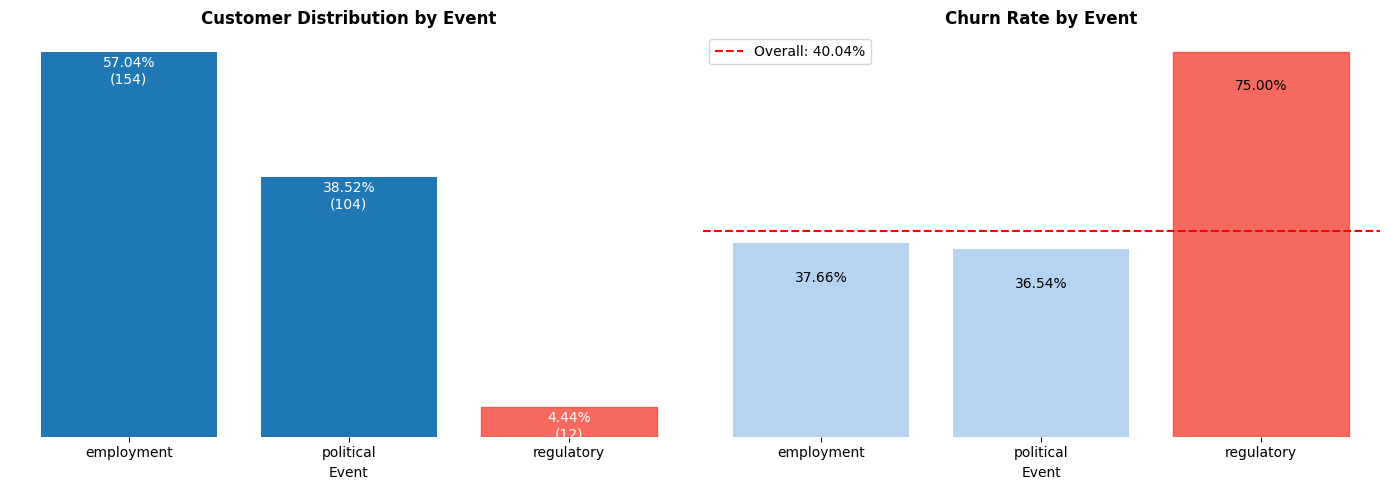

In [66]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bars1 = axes[0].bar(event_breakdown['event_type'], event_breakdown['total_customers'])
axes[0].set_title('Customer Distribution by Event', fontweight='bold')
axes[0].set_xlabel('Event')

# Add count and percentage using bar_label (inside bars, white color)
labels = [f'{count/total_event*100:.2f}%\n({int(count)})' for count in event_breakdown['total_customers']]
axes[0].bar_label(bars1, labels=labels, label_type='edge', padding=-25, color='white')

# Churn rate by event
bars2 = axes[1].bar(event_breakdown['event_type'], event_breakdown['churn_rate'], color='#B7D3F2')
axes[1].set_title('Churn Rate by Event', fontweight='bold')
axes[1].set_xlabel('Event')

# Add overall churn rate line
axes[1].axhline(y=overall_churn_rate, color='red', linestyle='--', label=f'Overall: {overall_churn_rate:.2f}%')
axes[1].legend()

# Color
bars1[2].set_color('#F44336')
bars1[2].set_alpha(0.8)
bars2[2].set_color('#F44336')
bars2[2].set_alpha(0.8)

# Add percentage using bar_label
axes[1].bar_label(bars2, labels=[f'{rate:.2f}%' for rate in event_breakdown['churn_rate']], label_type='edge', padding=-30)

# Clean up both axes
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
        ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()

External events do not meaningfully predict churn.
Only regulatory events as we saw earlier have an impact but it affects only 12 customers, it has negligible practical impact.

Churn is mostly driven by controllable internal factors (like plan type) rather than external events you can't control.

### 2.8 Time-Based Patterns

#### 2.8.1 Time when customers churn (early days vs later)

In [67]:
# Calculate days active
vpn_data['lifetime_days'] = (vpn_data['churn_date'] - vpn_data['signup_date']).dt.days

vpn_data['days_active'] = np.where(
    vpn_data['churned'] == 1,
    vpn_data['lifetime_days'],
    (vpn_data['signup_date'].max() - vpn_data['signup_date']).dt.days
)

# Create buckets
vpn_data['days_active_bucket'] = pd.cut(
    vpn_data['days_active'], 
    bins=[0, 30, 60, 90, 180, 365, np.inf],
    labels=['0-30 days', '31-60 days', '61-90 days', '91-180 days', '181-365 days', '365+ days']
)

vpn_data['days_active_bucket'].value_counts().sort_index()

days_active_bucket
0-30 days        9978
31-60 days       9028
61-90 days       7813
91-180 days     18816
181-365 days    27549
365+ days       26658
Name: count, dtype: int64

In [68]:
total_customers = (vpn_data.user_id).count()
mature_customers = vpn_data[vpn_data['days_active'] >= 91].shape[0]
mature_customers / total_customers

np.float64(0.73023)

Most of the customer base is mature: 73% have been active 91+ days.

In [69]:
# Calculate churn rate by bucket
bucket_churn_analysis = vpn_data.groupby('days_active_bucket', observed=True).agg({
    'user_id': 'count',
    'churned': 'mean'
}).reset_index()

bucket_churn_analysis.columns = ['bucket', 'total_customers', 'churn_rate']
bucket_churn_analysis['churn_rate'] = bucket_churn_analysis['churn_rate'] * 100
bucket_churn_analysis


,bucket,total_customers,churn_rate
0,0-30 days,9978,55.862898
1,31-60 days,9028,53.478068
2,61-90 days,7813,52.604633
3,91-180 days,18816,47.082270
4,181-365 days,27549,43.297397
5,365+ days,26658,17.795784


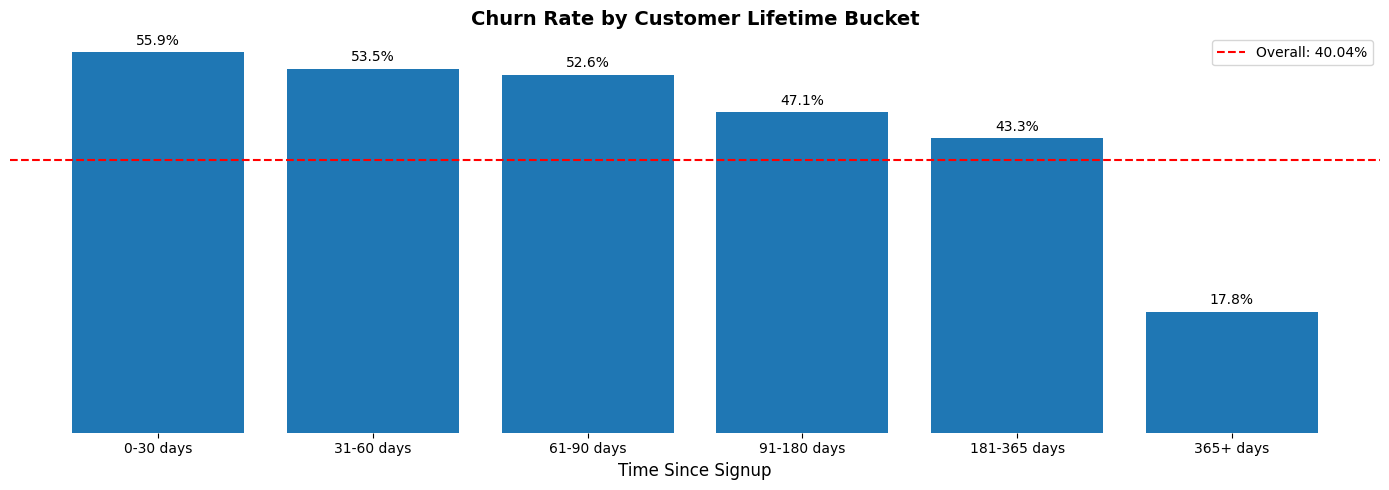

In [70]:
fig, ax = plt.subplots(figsize=(14, 5))

bars = ax.bar(bucket_churn_analysis['bucket'], bucket_churn_analysis['churn_rate'])

# Add overall churn rate line
ax.axhline(y=overall_churn_rate, color='red', linestyle='--', 
           label=f'Overall: {overall_churn_rate:.2f}%')

# Style
ax.set_title('Churn Rate by Customer Lifetime Bucket', fontweight='bold', fontsize=14)
ax.set_xlabel('Time Since Signup', fontsize=12)
ax.set_ylabel('Churn Rate (%)', fontsize=12)
ax.yaxis.set_visible(False)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels
ax.bar_label(bars, labels=[f'{v:.1f}%' for v in bucket_churn_analysis['churn_rate']], 
             padding=3)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [71]:
# Statistical Test: Chi-square test for days_active_bucket vs churn
# H0: Days active bucket and churn are independent
# H1: Days active bucket and churn are related

contingency_table = pd.crosstab(vpn_data['days_active_bucket'], vpn_data['churned'])
chi2, p_value = stats.chi2_contingency(contingency_table)[:2]

print("Chi-Square Test Results - Days Active Bucket vs Churn:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nConclusion: {'REJECT' if p_value < 0.05 else 'FAIL TO REJECT'} null hypothesis")
print(f"Days active bucket {'IS' if p_value < 0.05 else 'IS NOT'} significantly associated with churn.")

# How strong is the relationship? Calculate effect size (Cramér's V)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / n)

print(f"\nEffect Size (Cramér's V): {cramers_v:.4f}")
print(f"Effect strength: {'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'}")

test_results.append({
    'Variable': 'Days Active',
    'Test': 'Chi-square',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cramér's V: {cramers_v:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'
})

Chi-Square Test Results - Days Active Bucket vs Churn:
Chi-square statistic: 8233.3259
P-value: 0.0000

Conclusion: REJECT null hypothesis
Days active bucket IS significantly associated with churn.

Effect Size (Cramér's V): 0.2872
Effect strength: Small


**Customer lifetime is a churn predictor.**

Over half of new customers churn within their first 3 months.

We could think of different actions: 
- 90days Onboarding program: welcome emails with setup guide, usage tips at days 7, 15, 30, 60
- set up a warning system for customers with low usage in their first month
- celebrate 1 year anniversary with loyalty rewards
- taget offers to most high risk users with a free month at day 60 or an offer to convert monthly to yearly plan before day 90

#### 2.8.2 Seasonal effect by month

In [72]:
# Extract date features
vpn_data['signup_month_num'] = vpn_data['signup_date'].dt.month
vpn_data['signup_quarter'] = vpn_data['signup_date'].dt.quarter
vpn_data['signup_day_of_week'] = vpn_data['signup_date'].dt.dayofweek

In [73]:
# Signup Month vs Churn

contingency_table = pd.crosstab(vpn_data['signup_month_num'], vpn_data['churned'])
chi2, p_value = stats.chi2_contingency(contingency_table)[:2]

print(f"Chi-square: {chi2:.4f}, P-value: {p_value:.4f}")
print(f"Conclusion: {'REJECT' if p_value < 0.05 else 'FAIL TO REJECT'} null hypothesis")

# Effect size (Cramér's V)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"Cramér's V: {cramers_v:.4f} ({'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'})")

test_results.append({
    'Variable': 'Signup Month',
    'Test': 'Chi-square',
    'P-value': f'{p_value:.4f}',
    'Effect Size': f"Cramér's V: {cramers_v:.4f}",
    'Significant': 'YES' if p_value < 0.05 else 'NO',
    'Predictor': 'Negligible' if cramers_v < 0.1 else 'Small' if cramers_v < 0.3 else 'Medium' if cramers_v < 0.5 else 'Large'
})


Chi-square: 2187.4161, P-value: 0.0000
Conclusion: REJECT null hypothesis
Cramér's V: 0.1479 (Small)


**Signup month has a small but significant effect on churn.** Certain months do have higher or lower churn risk.

In [74]:
# Calculate churn rate by month
monthly_churn = vpn_data.groupby('signup_month_num')['churned'].agg(['count', 'mean']).reset_index()
monthly_churn.columns = ['month', 'total_customers', 'churn_rate']
monthly_churn['churn_rate'] = monthly_churn['churn_rate'] * 100

# Add month names
monthly_churn['month_name'] = monthly_churn['month'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})

# Calculate difference from average
avg_churn = vpn_data['churned'].mean() * 100
monthly_churn['diff_from_avg'] = monthly_churn['churn_rate'] - overall_churn_rate

monthly_churn.set_index('month_name')[['total_customers', 'churn_rate', 'diff_from_avg']]


,total_customers,churn_rate,diff_from_avg
month_name,,,
Jan,9196,25.804698,-14.238302
Feb,8263,44.959458,4.916458
Mar,8719,48.388577,8.345577
Apr,8055,47.088765,7.045765
May,7903,46.931545,6.888545
Jun,6940,45.936599,5.893599
Jul,7462,43.406593,3.363593
Aug,8444,42.586452,2.543452
Sep,8729,38.962080,-1.080920


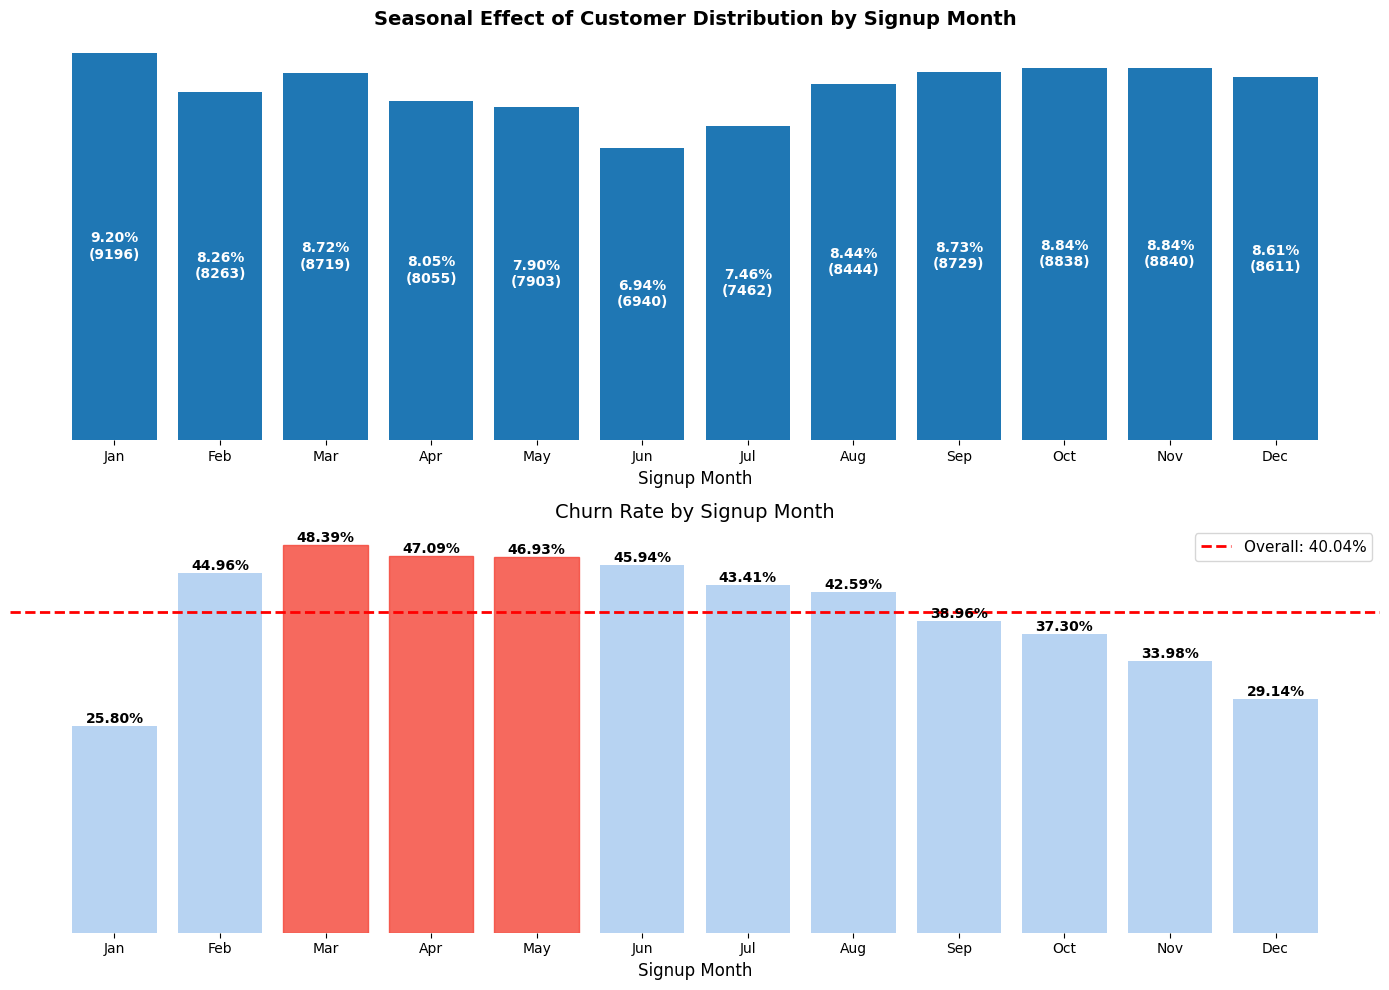

In [75]:
# Visualize monthly pattern
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Calculate total for percentage labels
total_monthly = monthly_churn['total_customers'].sum()

# Customer Distribution by Signup Month
bars1 = axes[0].bar(monthly_churn['month_name'], monthly_churn['total_customers'])
axes[0].set_title('Seasonal Effect of Customer Distribution by Signup Month', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Signup Month', fontsize=12)
axes[0].set_ylabel('', fontsize=12)

# Add count labels
labels = [f'{count/total_monthly*100:.2f}%\n({int(count)})' for count in monthly_churn['total_customers']]
axes[0].bar_label(bars1, labels=labels, label_type='center', color='white', fontweight='bold')

# Bottom: Churn Rate by Month
bars2 = axes[1].bar(monthly_churn['month_name'], monthly_churn['churn_rate'], color='#B7D3F2')
axes[1].set_title('Churn Rate by Signup Month', fontsize=14)
axes[1].set_xlabel('Signup Month', fontsize=12)
axes[1].set_ylabel('', fontsize=12)

# Add overall churn rate line
axes[1].axhline(y=overall_churn_rate, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_churn_rate:.2f}%')
axes[1].legend(fontsize=11)

# Add percentage labels
axes[1].bar_label(bars2, labels=[f'{rate:.2f}%' for rate in monthly_churn['churn_rate']], fontsize=10, fontweight='bold')

# Highlight high-risk months (Mar/Apr/May) with different color
high_risk_months = ['Mar', 'Apr', 'May']
for i, month in enumerate(monthly_churn['month_name']):
    if month in high_risk_months:
        bars2[i].set_color('#F44336')
        bars2[i].set_alpha(0.8)

# Clean up both axes
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Seasonal Pattern:

We notice that at the end of the year users who sign up are less  incline to churn Nov/Dec/Jan being months with the lowest churn rate. On the opposite, Mar/Apr/May correspond to the 3 months with the highest churn rate.

We notice a summer slow donw in customer acquisition with a mid-year signup drop in May/Jun/Jul.

- Q4 is the best acquisition period: more signups and lower churn. We could try to double down on Q4 marketing. They possibly are gift receivers or New Year's resolution users who stick. Winter signups are twice as likely to stay vs spring signups.
- Mar/Apr/May is the risky cohort with the highest churn. They could be trial-seekers or seasonal users
- Summer correspond to fewer signup, this is a slow season

We could target spring signups with retention campaigns:
- we would need to investigate why spring users churn more
- We could offer an annual plan discounts at 30 days for spring signups

#### 2.8.3 Seasonal effect by quarter

In [76]:
quarterly_analysis = vpn_data.groupby('signup_quarter').agg({
    'user_id': 'count',
    'churned': 'mean'
}).reset_index()

quarterly_analysis.columns = ['quarter', 'total_customers', 'churn_rate']
quarterly_analysis['churn_rate'] = quarterly_analysis['churn_rate'] * 100
quarterly_analysis['diff_from_avg'] = quarterly_analysis['churn_rate'] - overall_churn_rate

quarterly_analysis

,quarter,total_customers,churn_rate,diff_from_avg
0,1,26178,39.372756,-0.670244
1,2,22898,46.685300,6.642300
2,3,24635,41.550639,1.507639
3,4,26289,33.512115,-6.530885


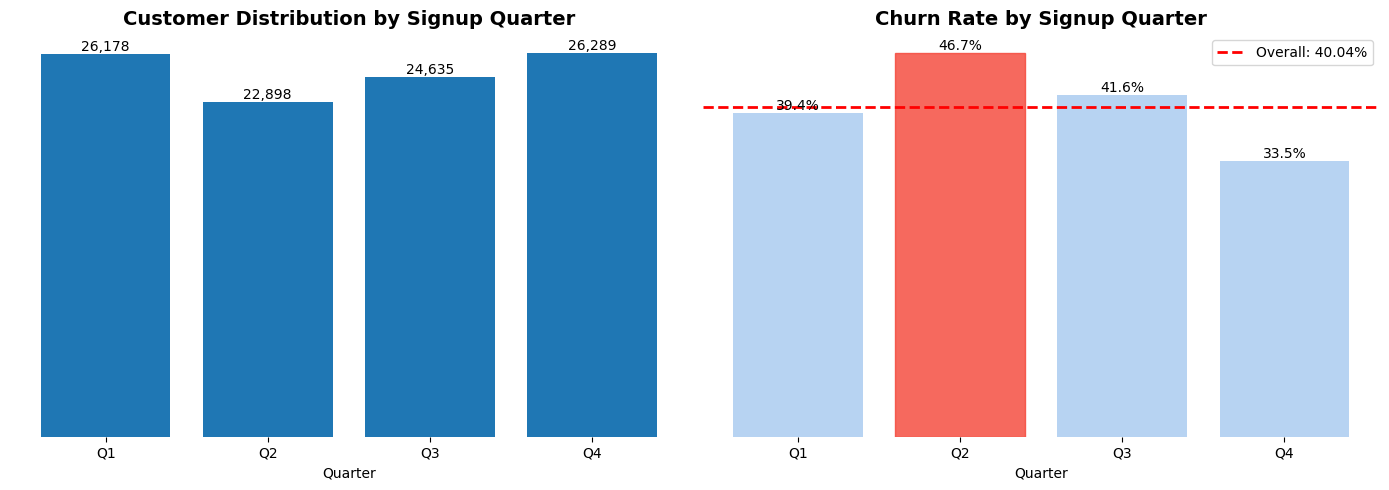

In [77]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total customers by quarter
bars1 = axes[0].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_analysis['total_customers'])
axes[0].set_title('Customer Distribution by Signup Quarter', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Quarter')
axes[0].bar_label(bars1, labels=[f'{int(v):,}' for v in quarterly_analysis['total_customers']], fontsize=10)

# Churn rate by quarter
bars2 = axes[1].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_analysis['churn_rate'], color='#B7D3F2')
axes[1].axhline(y=overall_churn_rate, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_churn_rate:.2f}%')
axes[1].set_title('Churn Rate by Signup Quarter', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Quarter')
axes[1].legend()
axes[1].bar_label(bars2, labels=[f'{v:.1f}%' for v in quarterly_analysis['churn_rate']],  fontsize=10)

# Highlight Q2 (highest churn) in red
bars2[1].set_color('#F44336')
bars2[1].set_alpha(0.8)

# Clean up
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Seasonal Pattern:

- Q4 is the best acquisition period: highest signups and lowest churn.
- Q2 is the risky cohort with the highest churn. There are also fewer signups. They could be trial-seekers or seasonal users

# Summary

In [78]:
# Convert test_results to DataFrame
summary_df = pd.DataFrame(test_results)

# Sort by predictor strength
predictor_order = {'Large': 1, 'Medium': 2, 'Small': 3, 'Negligible': 4}
summary_df['sort_order'] = summary_df['Predictor'].map(predictor_order)
summary_df = summary_df.sort_values('sort_order').drop('sort_order', axis=1).reset_index(drop=True)

# Add emoji indicators based on Predictor column (not Effect Size)
summary_df['Priority'] = summary_df['Predictor'].map({
    'Large': '🔴 HIGH',
    'Medium': '🟠 MEDIUM', 
    'Small': '🟡 LOW',
    'Negligible': '⚪ IGNORE'
})

# Reorder columns
summary_df = summary_df[['Priority', 'Variable', 'Test', 'P-value', 'Effect Size', 'Significant', 'Predictor']]

print("\n" + "="*80)
print("STATISTICAL TEST SUMMARY - CHURN PREDICTORS".center(80))
print("="*80 + "\n")

summary_df


                  STATISTICAL TEST SUMMARY - CHURN PREDICTORS                   



,Priority,Variable,Test,P-value,Effect Size,Significant,Predictor
0,🔴 HIGH,Plan Type,Chi-square,0.0000,Cramér's V: 0.5048,YES,Large
1,🟡 LOW,Days Active,Chi-square,0.0000,Cramér's V: 0.2872,YES,Small
2,🟡 LOW,Signup Month,Chi-square,0.0000,Cramér's V: 0.1479,YES,Small
3,⚪ IGNORE,Monthly Usage Hours,T-test,0.0000,Cohen's d: 0.0818,YES,Negligible
4,⚪ IGNORE,Number of distinct devices,T-test,0.7845,Cohen's d: -0.0018,NO,Negligible
5,⚪ IGNORE,Device diversity,Chi-square,0.9854,Cramér's V: 0.0001,NO,Negligible
6,⚪ IGNORE,Countries connected to,T-test,0.1156,Cohen's d: 0.0102,NO,Negligible
7,⚪ IGNORE,Number of support tickets,T-test,0.7165,Cohen's d: 0.0023,NO,Negligible
8,⚪ IGNORE,Support ticket type,Chi-square,0.2404,Cramér's V: 0.0037,NO,Negligible
9,⚪ IGNORE,Signup Country,Chi-square,0.0000,Cramér's V: 0.0189,YES,Negligible


# EXECUTIVE SUMMARY

Proton VPN faces a **40.04% churn rate** over the customer base, meaning 2 out of 5 customers leave. Through statistical analysis of 100 000 customers, we've identified some root causes and actionable solutions.

---

### Key Findings: What Actually Drives Churn

After testing 12 potential churn factors, only 3 show meaningful impact:

#### **1. Plan Type: The #1 Churn Driver**
- **Monthly plans**: 61.61% churn rate
- **Annual plans**: 11.67% churn rate
- **Impact**: Monthly subscribers are **more likely to churn**
- **Effect size**: Large

**This is the single most important finding.** Plan type alone explains most of the churn problem.

---

#### **2. Customer Lifetime: The 90-Day Window**
- **First 30 days**: 55.9% churn
- **Days 31-60**: 53.5% churn
- **Days 61-90**: 52.6% churn
- **After 90 days**: <35% churn

**The first 3 months are make-or-break.** If customers survive their first quarter, they're likely to stay long-term.

---

#### **3. Seasonality: Spring vs Winter Effect**
- **Q2 signups**: 46.7% churn
- **Q4 signups**: 33.5% churn
- **Difference**: Spring signups are more likely to churn

**Seasonal patterns matter,** but less than plan type and customer lifetime.

---

### Potential Churn Factors that Don't Matter

Through statistical testing, we **rejected** these common assumptions:

| Factor | Why It Doesn't Predict Churn |
|--------|------------------------------|
| **Usage hours** | Churned vs retained customers differ by only 7 hours/month (14 min/day) |
| **Number of devices** | No correlation between device diversity and retention |
| **Device type** | Desktop, mobile, tablet, smart-TV users churn at the same rate |
| **Support tickets** | Filing tickets (or not) doesn't predict churn |
| **Geographic location** | Country of signup shows negligible effect |
| **External events** | Regulatory changes, data breaches, employment shifts have minimal impact |

**Key insight**: Customer behavior metrics (usage, devices, geography) are **not predictive**. Churn is driven by **contract structure** (monthly vs annual) and **onboarding failure** (first 90 days).

---

### Strategic Implications

#### **The Real Problem**
This isn't a product quality issue (support tickets don't correlate with churn). This isn't a targeting issue (geography doesn't matter). **This looks like a pricing and onboarding problem.**

#### **The Opportunity**
- 56.8% of customers are on monthly plans (high churn)
- 73% of the customer base has been active 91+ days (mature, low churn)
- **If we can convert monthly to annual and improve first-90-day retention, we would cut churn**

---

### Recommended Actions (Ranked by Impact)

#### **Priority 1: Monthly-to-Annual Conversion Campaign**
**Target**: Reduce monthly plan share from 56.8% to 50% or 40%

**Tactics**:
1. 30-day upgrade offer: "Lock in your rate + 2 months free"
2. Increase monthly price by 15-20% to make annual more attractive
3. Make annual the default/recommended option for new signups

**Expected impact**:
**Today:**
- 56.8% monthly customers × 61.61% churn = 35% of all customers churn
- 43,2% annual customers × 11.67% churn = 5% of all customers churn
- **Total: 40% churn**

**If we convert 17% to annual (move to 40% monthly):**
- 40% monthly × 61.61% churn = 24.6% churn
- 60% annual × 11.67% churn = 7% churn
- **Total: 31.6% churn**

**Result: Drop from 40% to 31.6% churn = Save 8 400 customers/year**

**If we convert 17% to annual (move to 40% monthly):**
- 50% monthly × 61.61% churn = 30.8% churn
- 50% annual × 11.67% churn = 5.8% churn
- **Total: 36.6% churn**

**Result: Drop from 40% to 36.6% churn = Save 3 400 customers/year**

---

#### **Priority 2: 90-Day Onboarding Program**
**Target**: Reduce 90-day churn from 54.1% to 45%

**Tactics**:
- **Day 1-7**: Welcome sequence, setup tutorials
- **Day 15**: Usage check-in for low-activity users
- **Day 30**: First milestone celebration + annual upgrade offer
- **Day 60**: Intervention for at-risk customers (low usage + monthly plan)
- **Day 90**: Loyalty reward to reinforce commitment

**Expected impact**: 
**Today:**
- 26.9% of customers are in first 90 days × 54.1% churn = 14.5% of all customers churn early
- 73% of customers are 90+ days × 35% churn = 25.5% of all customers churn later
- **Total: 40% churn**

**If onboarding reduces early churn to 45%:**
- 26.9% early customers × 45% churn = 12.1% churn early
- 73% mature customers × 35% churn = 25.5% churn later
- **Total: 37.6% churn**

**Result: Drop from 40% to 37.6% churn = Save ~2,400 customers/year**

---

#### **Priority 3: Seasonal Targeting**
**Target**: Reduce Q2 cohort churn from 46.7% to 40%

**Tactics**:
- **Q4 marketing blitz**: Double down on holiday/New Year campaigns
- **Q2 cohort rescue**: Intensive onboarding + aggressive annual discounts for spring signups
- **Summer strategy**: Travel-focused VPN campaigns during slow season

*Expected impact**:
**Today:**
- 22.9% of customers sign up in Q2 × 46.7% churn = 10.7% of all customers churn from Q2
- 77.1% of customers sign up in other quarters × 38% churn = 29.3% of all customers churn from other quarters
- **Total: 40% churn**

**If Q2 targeting reduces Q2 churn to 40%:**
- 22.9% Q2 customers × 40% churn = 9.1% churn from Q2
- 77.1% other quarters × 38% churn = 29.3% churn from other quarters
- **Total: 38.4% churn**

**Result: Drop from 40% to 38.4% churn = Save ~1,600 customers/year**

---

### Expected Business Impact

**ROI Calculation by Priority:**

| Priority | Impact | Customers Saved/Year | Revenue Impact* |
|----------|--------|---------------------|-----------------|
| **1. Monthly→Annual** | -8.4pp churn | ~8,400 | $84K |
| **2. 90-Day Onboarding** | -2.4pp churn | ~2,400 | $24K |
| **3. Seasonal Targeting** | -1.6pp churn | ~1,600 | $16K |
| **Combined Total** | **-12.4pp churn** | **~12,400** | **$124K** |

*Based on 100,000 customer base and $10 average monthly revenue

---

### Methodology Note

All findings are based on statistical testing:
- **Chi-square tests** for categorical relationships
- **T-tests** for continuous variable differences
- **Effect size calculations** (Cramér's V, Cohen's d) to distinguish statistical significance from practical significance
- **P-value threshold**: 0.05
- **Effect size thresholds**: Negligible (<0.1), Small (0.1-0.3), Medium (0.3-0.5), Large (>0.5) for Chi-square test and Negligible (<0.2), Small (0.2-0.5), Medium (0.5-0.8), Large (>0.8) for t-test 

**Key principle**: We focused on **practical significance**, not just statistical significance. A statistically significant result with negligible effect size (like geography) is not actionable.

---

### Key Takeaways

1. Monthly plans are bleeding customers. Converting them to annual is the highest-leverage action.

2. Onboarding is critical. Most customers who survive 3 months become long-term subscribers.

3. Ignore vanity metrics: Usage hours, device counts, and geography don't predict churn. Focus on what matters: contract type and time-since-signup.

4. Seasonal opportunities exist: Q4 is your best acquisition window. Q2 needs special attention.

5. You can't control regulatory events or economic downturns. Focus on controllable internal factors.

**The path forward is clear**: Convert monthly to annual, nail the onboarding experience, and optimize seasonal campaigns. These three actions can help reduce churn by nearly 13%.

# Extract images

In [79]:
from bs4 import BeautifulSoup
import os, base64

html_path = "DataAnalystHomeAssignment.html"
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

with open(html_path, "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f, "html.parser")

count = 0
for img in soup.find_all("img"):
    src = img.get("src", "")
    if src.startswith("data:image/png;base64,"):
        count += 1
        img_data = base64.b64decode(src.split(",")[1])
        with open(f"{output_dir}/image_{count}.png", "wb") as f:
            f.write(img_data)
        print(f"Saved: image_{count}.png")

print(f"\nExtracted {count} images to '{output_dir}'")

Saved: image_1.png
Saved: image_2.png
Saved: image_3.png
Saved: image_4.png
Saved: image_5.png
Saved: image_6.png
Saved: image_7.png
Saved: image_8.png
Saved: image_9.png
Saved: image_10.png
Saved: image_11.png
Saved: image_12.png
Saved: image_13.png
Saved: image_14.png
Saved: image_15.png

Extracted 15 images to 'output_images'
